## Installation et importation des bibliothèques nécessaires

In [93]:
# Installation des bibliothèques nécessaires
!pip install scikit-image
!pip install opencv-python
!pip install mahotas
!pip install tqdm
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install joblib

# Importation des bibliothèques standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import time
from tqdm import tqdm


# Bibliothèques pour le traitement d'images
from skimage import io, color, filters, feature, morphology
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
import mahotas as mh

# Bibliothèques pour le ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

# Pour les visualisations interactives dans Jupyter
%matplotlib inline

## Vérification des données

In [95]:
# Vérification de la structure du dossier de données
data_path = "data"  # Ajustez si votre dossier a un nom différent
print("Contenu du dossier de données:")
print(os.listdir(data_path))

# Afficher le nombre d'images par classe
class_counts = {}
for class_name in os.listdir(data_path):
    class_dir = os.path.join(data_path, class_name)
    if os.path.isdir(class_dir):
        count = len(glob.glob(os.path.join(class_dir, "*.jpg")))
        class_counts[class_name] = count
        print(f"Classe '{class_name}': {count} images")

Contenu du dossier de données:
['cloudy', 'desert', 'green_area', 'water']
Classe 'cloudy': 1500 images
Classe 'desert': 1131 images
Classe 'green_area': 1500 images
Classe 'water': 1500 images


## Fonctions de traitement morphologiques

In [97]:
def segment_image_morphology(image, method='watershed'):
    """
    Segmente l'image en utilisant des techniques morphologiques
    
    Args:
        image: Image d'entrée
        method: Méthode de segmentation ('watershed', 'region_growing')
    
    Returns:
        Image segmentée et labels des segments
    """
    # Conversion en niveaux de gris si nécessaire
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    if method.lower() == 'watershed':
        # Segmentation watershed
        # Calcul du gradient pour trouver les bordures
        gradient = apply_morphological_operation(blurred, 'gradient', 3)
        
        # Binarisation du gradient
        _, binary = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Transformation de distance
        dist = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
        
        # Binarisation de la transformation de distance
        _, dist_bin = cv2.threshold(dist, 0.5*dist.max(), 255, cv2.THRESH_BINARY)
        dist_bin = dist_bin.astype(np.uint8)
        
        # Recherche des marqueurs (noyaux des régions)
        contours, _ = cv2.findContours(dist_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        markers = np.zeros_like(gray)
        for i, contour in enumerate(contours):
            cv2.drawContours(markers, [contour], -1, i+1, -1)
        
        # Appliquer watershed
        if len(image.shape) == 2:
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image_color = image.copy()
        
        markers_copy = markers.copy()
        cv2.watershed(image_color, markers_copy)
        
        return markers_copy, len(contours)
    
    elif method.lower() == 'region_growing':
        # Implémentation simplifiée de croissance de région
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Trouver les composantes connectées
        num_labels, labels = cv2.connectedComponents(binary)
        
        return labels, num_labels - 1
    
    else:
        # Méthode par défaut: simple seuillage adaptatif
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
        
        num_labels, labels = cv2.connectedComponents(binary)
        
        return labels, num_labels - 1
print("Traitement morphologique terminé.")

Traitement morphologique terminé.


## Fonctions de segmentation 

In [99]:
def segment_image_morphology(image, method='watershed'):
    """
    Segmente l'image en utilisant des techniques morphologiques
    
    Args:
        image: Image d'entrée
        method: Méthode de segmentation ('watershed', 'region_growing')
    
    Returns:
        Image segmentée et labels des segments
    """
    # Conversion en niveaux de gris si nécessaire
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    if method.lower() == 'watershed':
        # Segmentation watershed
        # Calcul du gradient pour trouver les bordures
        gradient = apply_morphological_operation(blurred, 'gradient', 3)
        
        # Binarisation du gradient
        _, binary = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Transformation de distance
        dist = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
        
        # Binarisation de la transformation de distance
        _, dist_bin = cv2.threshold(dist, 0.5*dist.max(), 255, cv2.THRESH_BINARY)
        dist_bin = dist_bin.astype(np.uint8)
        
        # Recherche des marqueurs (noyaux des régions)
        contours, _ = cv2.findContours(dist_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        markers = np.zeros_like(gray)
        for i, contour in enumerate(contours):
            cv2.drawContours(markers, [contour], -1, i+1, -1)
        
        # Appliquer watershed
        if len(image.shape) == 2:
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image_color = image.copy()
        
        markers_copy = markers.copy()
        cv2.watershed(image_color, markers_copy)
        
        return markers_copy, len(contours)
    
    elif method.lower() == 'region_growing':
        # Implémentation simplifiée de croissance de région
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Trouver les composantes connectées
        num_labels, labels = cv2.connectedComponents(binary)
        
        return labels, num_labels - 1
    
    else:
        # Méthode par défaut: simple seuillage adaptatif
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
        
        num_labels, labels = cv2.connectedComponents(binary)
        
        return labels, num_labels - 1
print("Traitement de segmentation terminé.")

Traitement de segmentation terminé.


## Extractions des caractéristiques de texture

In [101]:
def extract_texture_features(image):
    """
    Extrait les caractéristiques de texture d'une image
    
    Args:
        image: Image en niveaux de gris
        
    Returns:
        Vecteur de caractéristiques
    """
    # Si l'image est en couleur, la convertir en niveaux de gris
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Redimensionner l'image pour normaliser
    resized = cv2.resize(gray, (128, 128))
    
    # Caractéristiques GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(resized, distances, angles, 256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    
    # Caractéristiques statistiques
    mean = np.mean(resized)
    std = np.std(resized)
    
    # Caractéristiques de Haralick avec Mahotas
    haralick = mh.features.haralick(resized).mean(axis=0)
    
    # Caractéristiques LBP (Local Binary Pattern)
    lbp = local_binary_pattern(resized, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp, bins=10, range=(0, 10))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-6)
    
    # Caractéristiques morphologiques
    # Gradient
    gradient = apply_morphological_operation(resized, 'gradient', 3)
    mean_gradient = np.mean(gradient)
    std_gradient = np.std(gradient)
    
    # Concatenation de toutes les caractéristiques
    features = np.concatenate([
        contrast, dissimilarity, homogeneity, energy, correlation,
        [mean, std, mean_gradient, std_gradient],
        haralick,
        hist_lbp
    ])
    
    return features

## Préparation du dataset et entraînement

In [103]:
def prepare_dataset(data_dir, sample_limit=None):
    """
    Prépare un jeu de données pour l'entraînement
    
    Args:
        data_dir: Répertoire contenant les images classées par dossiers
        sample_limit: Limite du nombre d'échantillons par classe (None = tous)
        
    Returns:
        X: Caractéristiques
        y: Étiquettes de classe
        class_names: Noms des classes
    """
    X = []
    y = []
    
    class_names = os.listdir(data_dir)
    class_names = [c for c in class_names if os.path.isdir(os.path.join(data_dir, c))]
    
    print(f"Classes trouvées: {class_names}")
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        class_samples = glob.glob(os.path.join(class_path, "*.jpg"))
        
        if sample_limit:
            class_samples = class_samples[:sample_limit]
        
        print(f"Traitement de {len(class_samples)} images pour la classe '{class_name}'...")
        
        for sample_path in tqdm(class_samples):
            try:
                # Charger l'image
                img = cv2.imread(sample_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Extraire les caractéristiques
                features = extract_texture_features(img)
                
                # Ajouter aux listes
                X.append(features)
                y.append(class_idx)
            except Exception as e:
                print(f"Erreur lors du traitement de {sample_path}: {e}")
    
    return np.array(X), np.array(y), class_names

def train_classifier(X_train, y_train):
    """
    Entraîne un classifieur pour les types de terrain
    
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        
    Returns:
        Modèle entraîné
    """
    # Création d'un pipeline avec normalisation et classification
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # Paramètres pour la recherche par grille
    param_grid = {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5]
    }
    
    # Recherche par grille avec validation croisée
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Meilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur score de validation croisée: {grid_search.best_score_:.4f}")
    print("Modèle entrainé.")
    
    return grid_search.best_estimator_


In [104]:
def apply_morphological_operation(image, operation, kernel_size):
    """
    Applique une opération morphologique à l'image
    
    Args:
        image: Image d'entrée
        operation: Nom de l'opération ('erosion', 'dilation', etc.)
        kernel_size: Taille du noyau (élément structurant)
    
    Returns:
        Image après application de l'opération
    """
    # Conversion en niveaux de gris si l'image est en couleur
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Création du noyau
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    # Application de l'opération
    if operation.lower() == 'erosion':
        result = cv2.erode(gray, kernel, iterations=1)
    elif operation.lower() == 'dilation':
        result = cv2.dilate(gray, kernel, iterations=1)
    elif operation.lower() == 'ouverture':
        result = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    elif operation.lower() == 'fermeture':
        result = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    elif operation.lower() == 'gradient':
        result = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)
    elif operation.lower() == 'top-hat':
        result = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    elif operation.lower() == 'black-hat':
        result = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    else:
        result = gray  # Opération non reconnue
    
    return result

def calculate_morphological_laplacian(image, kernel_size):
    """
    Calcule le laplacien morphologique: (dilation(dilation(img)) - 2*dilation(img) + img)
    """
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
        
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    # Première et seconde dilatation
    dilated = cv2.dilate(gray, kernel, iterations=1)
    double_dilated = cv2.dilate(dilated, kernel, iterations=1)
    
    # Laplacien morphologique
    laplacian = cv2.subtract(double_dilated, cv2.add(dilated, dilated))
    laplacian = cv2.add(laplacian, gray)
    
    return laplacian

def calculate_gradient_morphology(image, kernel_size=3):
    """
    Calcule les trois types de gradients morphologiques:
    - Gradient interne: différence entre l'image originale et son érosion
    - Gradient externe: différence entre la dilatation et l'image originale
    - Gradient morphologique symétrique: différence entre la dilatation et l'érosion
    """
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    # Érosion et dilatation
    erosion = cv2.erode(gray, kernel, iterations=1)
    dilation = cv2.dilate(gray, kernel, iterations=1)
    
    # Gradients
    internal_gradient = cv2.subtract(gray, erosion)
    external_gradient = cv2.subtract(dilation, gray)
    morphological_gradient = cv2.subtract(dilation, erosion)
    
    return internal_gradient, external_gradient, morphological_gradient

def segment_image_morphology(image, method='watershed'):
    """
    Segmente l'image en utilisant des techniques morphologiques
    
    Args:
        image: Image d'entrée
        method: Méthode de segmentation ('watershed', 'region_growing')
    
    Returns:
        Image segmentée et labels des segments
    """
    # Conversion en niveaux de gris si nécessaire
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
        image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # Convertir en BGR pour watershed
    
    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    if method.lower() == 'watershed':
        # Segmentation watershed
        # Calcul du gradient pour trouver les bordures
        gradient = apply_morphological_operation(blurred, 'gradient', 3)
        
        # Binarisation du gradient
        _, binary = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Transformation de distance
        dist = cv2.distanceTransform(binary, cv2.DIST_L2, 3)
        
        # Binarisation de la transformation de distance
        _, dist_bin = cv2.threshold(dist, 0.5*dist.max(), 255, cv2.THRESH_BINARY)
        dist_bin = dist_bin.astype(np.uint8)
        
        # Recherche des marqueurs (noyaux des régions)
        contours, _ = cv2.findContours(dist_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Créer une matrice de marqueurs avec le type correct (CV_32SC1)
        markers = np.zeros(gray.shape, dtype=np.int32)
        
        # Dessiner les contours des régions
        for i, contour in enumerate(contours):
            cv2.drawContours(markers, [contour], -1, i+1, -1)
        
        # Préparer l'image pour watershed (doit être CV_8UC3)
        if len(image.shape) < 3 or image.shape[2] != 3:
            image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        else:
            image_color = image.copy()
        
        # Appliquer watershed
        cv2.watershed(image_color, markers)
        
        return markers, len(contours)
    
    elif method.lower() == 'region_growing':
        # Implémentation simplifiée de croissance de région
        _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Trouver les composantes connectées
        num_labels, labels = cv2.connectedComponents(binary)
        
        return labels, num_labels - 1
    
    else:
        # Méthode par défaut: simple seuillage adaptatif
        binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)
        
        num_labels, labels = cv2.connectedComponents(binary)
        
        return labels, num_labels - 1

## Fonctions de visualisation 

In [106]:
def visualize_sample_images(data_dir, n_samples=5):
    """
    Visualise quelques exemples d'images pour chaque classe
    """
    classes = os.listdir(data_dir)
    classes = [c for c in classes if os.path.isdir(os.path.join(data_dir, c))]
    
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(15, 3*len(classes)))
    
    for i, class_name in enumerate(classes):
        class_samples = glob.glob(os.path.join(data_dir, class_name, '*.jpg'))
        selected_samples = np.random.choice(class_samples, min(n_samples, len(class_samples)), replace=False)
        
        for j, sample in enumerate(selected_samples):
            img = io.imread(sample)
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_morphological_operations(image, kernel_size=5):
    """
    Visualise les résultats de différentes opérations morphologiques
    """
    operations = ['erosion', 'dilation', 'ouverture', 'fermeture', 'gradient', 'top-hat', 'black-hat']
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Image originale
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        axes[0].imshow(image)
    else:
        gray = image.copy()
        axes[0].imshow(gray, cmap='gray')
    
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    
    # Appliquer et afficher les opérations
    for i, operation in enumerate(operations):
        result = apply_morphological_operation(image, operation, kernel_size)
        axes[i+1].imshow(result, cmap='gray')
        axes[i+1].set_title(f'{operation.capitalize()}, kernel={kernel_size}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_segmentation(image, method='watershed'):
    """
    Visualise le résultat de la segmentation
    """
    # Segmenter l'image
    labels, n_segments = segment_image_morphology(image, method=method)
    
    # Créer une image segmentée en couleur
    if len(image.shape) == 2:
        image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_color = image.copy()
    
    # Créer une version colorée des labels pour visualisation
    label_viz = np.zeros_like(image_color)
    
    # Générer des couleurs aléatoires pour chaque label
    np.random.seed(42)  # Pour la reproductibilité
    colors = np.random.randint(0, 255, size=(n_segments + 2, 3), dtype=np.uint8)
    colors[0] = [0, 0, 0]  # Fond en noir
    
    # Colorier les segments
    for i in range(1, n_segments + 2):
        label_viz[labels == i] = colors[i]
    
    # Afficher
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(image_color)
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    
    axes[1].imshow(labels, cmap='jet')
    axes[1].set_title(f'Labels ({n_segments} segments)')
    axes[1].axis('off')
    
    axes[2].imshow(label_viz)
    axes[2].set_title('Segmentation colorée')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return labels, n_segments

def visualize_gradient_types(image, kernel_size=3):
    """
    Visualise les différents types de gradients morphologiques
    """
    # Calculer les gradients
    internal, external, morphological = calculate_gradient_morphology(image, kernel_size)
    
    # Afficher
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        axes[0].imshow(image)
    else:
        gray = image.copy()
        axes[0].imshow(gray, cmap='gray')
    
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    
    axes[1].imshow(internal, cmap='gray')
    axes[1].set_title('Gradient interne')
    axes[1].axis('off')
    
    axes[2].imshow(external, cmap='gray')
    axes[2].set_title('Gradient externe')
    axes[2].axis('off')
    
    axes[3].imshow(morphological, cmap='gray')
    axes[3].set_title('Gradient morphologique')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()

In [107]:
def analyze_feature_importance(model, feature_names=None):
    """
    Analyse et visualise l'importance des caractéristiques du modèle RandomForest
    
    Args:
        model: Modèle entraîné (avec RandomForestClassifier)
        feature_names: Noms des caractéristiques (optionnel)
    """
    # Vérifier si le modèle est un pipeline
    if hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
        classifier = model.named_steps['classifier']
    else:
        classifier = model
    
    # Vérifier si c'est un RandomForest
    if not hasattr(classifier, 'feature_importances_'):
        print("Le modèle n'est pas un RandomForest ou n'a pas d'attribut 'feature_importances_'")
        return
    
    # Obtenir l'importance des caractéristiques
    importances = classifier.feature_importances_
    
    # Créer des noms de caractéristiques par défaut si non spécifiés
    if feature_names is None:
        # Caractéristiques GLCM
        glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        distances = [1, 2, 3]
        angles = [0, 45, 90, 135]
        glcm_features = [f"{prop}_d{d}_a{a}" for prop in glcm_props 
                         for d in distances for a in angles]
        
        # Caractéristiques statistiques
        stat_features = ['mean', 'std', 'mean_gradient', 'std_gradient']
        
        # Caractéristiques Haralick (13 caractéristiques)
        haralick_features = [f'haralick_{i}' for i in range(13)]
        
        # Caractéristiques LBP (10 bins d'histogramme)
        lbp_features = [f'lbp_bin_{i}' for i in range(10)]
        
        feature_names = glcm_features + stat_features + haralick_features + lbp_features
    
    # Trier les caractéristiques par importance
    indices = np.argsort(importances)[::-1]
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(12, 8))
    
    # Montrer les 20 caractéristiques les plus importantes
    n_features = min(20, len(importances))
    plt.barh(range(n_features), importances[indices[:n_features]], align='center')
    plt.yticks(range(n_features), [feature_names[i] for i in indices[:n_features]])
    plt.xlabel('Importance')
    plt.ylabel('Caractéristique')
    plt.title('Importance des caractéristiques')
    plt.tight_layout()
    plt.show()
    
    # Retourner les importances triées
    top_features = [(feature_names[i], importances[i]) for i in indices[:n_features]]
    return top_features

## Fonctions pour la classification et la création de cartes de segmentation

In [109]:
def create_segmentation_map(image, model, class_names):
    """
    Crée une carte de segmentation avec classification des régions
    
    Args:
        image: Image à analyser
        model: Modèle de classification
        class_names: Noms des classes
    """
    # Segmentation de l'image
    labels, n_segments = segment_image_morphology(image, method='watershed')
    
    # Classification de chaque segment
    segment_classes = {}
    
    # Image segmentée pour la visualisation
    segmented = np.zeros_like(image)
    
    # Si l'image est en niveaux de gris, la convertir en RGB
    if len(image.shape) == 2:
        image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_color = image.copy()
    
    # Couleurs pour chaque classe (à adapter selon vos classes spécifiques)
    colors = {}
    for i, name in enumerate(class_names):
        hue = i * 180 // len(class_names)
        # Convertir HSV en RGB pour générer des couleurs distinctes
        rgb = cv2.cvtColor(np.uint8([[[hue, 255, 255]]]), cv2.COLOR_HSV2RGB)[0][0]
        colors[name] = rgb.tolist()
    
    # Analyser chaque segment
    for segment_id in range(1, n_segments + 2):
        # Créer un masque pour le segment actuel
        mask = (labels == segment_id)
        if not np.any(mask):
            continue
            
        # Extraire la région correspondante de l'image originale
        segment_img = image.copy()
        if len(image.shape) == 3:
            for c in range(3):
                segment_img[:,:,c] = segment_img[:,:,c] * mask
        else:
            segment_img = segment_img * mask
        
        # Calculer les caractéristiques de texture
        try:
            features = extract_texture_features(segment_img)
            
            # Prédire la classe
            predicted_class_idx = model.predict([features])[0]
            predicted_class = class_names[predicted_class_idx]
            
            # Stocker la classe prédite
            segment_classes[segment_id] = predicted_class
            
            # Colorier le segment
            if predicted_class in colors:
                if len(image.shape) == 3:
                    for c in range(3):
                        segmented[:,:,c][mask] = colors[predicted_class][c]
                else:
                    segmented[mask] = colors[predicted_class][0]  # Utiliser seulement le canal rouge
        except Exception as e:
            print(f"Erreur lors de la classification du segment {segment_id}: {e}")
    
    # Créer une version blended (superposition semi-transparente)
    alpha = 0.7
    blended = cv2.addWeighted(image_color, 1 - alpha, segmented.astype(np.uint8), alpha, 0)
    
    # Afficher les résultats
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(image_color)
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    
    axes[1].imshow(segmented)
    axes[1].set_title('Classification des segments')
    axes[1].axis('off')
    
    axes[2].imshow(blended)
    axes[2].set_title('Superposition')
    axes[2].axis('off')
    
    # Ajouter une légende
    patches = []
    for class_name in class_names:
        if class_name in colors:
            color_rgb = np.array(colors[class_name]) / 255.0
            patch = plt.Rectangle((0, 0), 1, 1, fc=color_rgb)
            patches.append(patch)
    
    fig.legend(patches, class_names, loc='lower center', ncol=len(class_names), bbox_to_anchor=(0.5, -0.05))
    
    plt.tight_layout()
    plt.show()
    
    # Analyser la distribution des types de terrain
    class_counts = {}
    for class_name in segment_classes.values():
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1
    
    # Afficher la distribution sous forme de diagramme circulaire
    plt.figure(figsize=(8, 8))
    plt.pie(list(class_counts.values()), labels=list(class_counts.keys()), autopct='%1.1f%%')
    plt.title('Distribution des types de terrain')
    plt.show()
    
    return segmented, segment_classes, blended

def compare_segmentation_methods(image):
    """
    Compare différentes méthodes de segmentation
    
    Args:
        image: Image à segmenter
    """
    methods = ['watershed', 'region_growing']
    
    fig, axes = plt.subplots(1, len(methods) + 1, figsize=(5 * (len(methods) + 1), 5))
    
    # Image originale
    if len(image.shape) == 2:
        axes[0].imshow(image, cmap='gray')
    else:
        axes[0].imshow(image)
    axes[0].set_title('Image originale')
    axes[0].axis('off')
    
    # Résultats des différentes méthodes
    for i, method in enumerate(methods):
        labels, n_segments = segment_image_morphology(image, method=method)
        
        # Afficher les labels en couleurs
        axes[i + 1].imshow(labels, cmap='jet')
        axes[i + 1].set_title(f'Méthode: {method}\n{n_segments} segments')
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [110]:
def analyze_satellite_image(image_path, model, class_names):
    """
    Effectue une analyse complète d'une image satellite
    
    Args:
        image_path: Chemin vers l'image à analyser
        model: Modèle de classification entraîné
        class_names: Noms des classes
    """
    print(f"Analyse de l'image: {image_path}")
    
    # Charger et prétraiter l'image
    image = load_and_process_image(image_path)
    
    # Afficher l'image originale
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title('Image satellite')
    plt.axis('off')
    plt.show()
    
    # 1. Appliquer et visualiser les opérations morphologiques
    print("\n1. Opérations morphologiques")
    visualize_morphological_operations(image)
    
    # 2. Analyser les gradients morphologiques
    print("\n2. Gradients morphologiques")
    visualize_gradient_types(image)
    
    # 3. Comparer les méthodes de segmentation
    print("\n3. Comparaison des méthodes de segmentation")
    compare_segmentation_methods(image)
    
    # 4. Analyser les caractéristiques de texture
    print("\n4. Analyse des textures")
    features = analyze_texture_features(image)
    
    # 5. Créer une carte de segmentation avec classification
    print("\n5. Segmentation et classification")
    segmented, segment_classes, blended = create_segmentation_map(image, model, class_names)
    
    # 6. Afficher un résumé des résultats
    print("\n6. Résumé des résultats")
    class_distribution = {}
    for class_name in segment_classes.values():
        if class_name in class_distribution:
            class_distribution[class_name] += 1
        else:
            class_distribution[class_name] = 1
    
    print("Distribution des types de terrain:")
    for class_name, count in class_distribution.items():
        percentage = count / len(segment_classes) * 100
        print(f"  {class_name}: {count} segments ({percentage:.1f}%)")
    
    return segmented, segment_classes, blended
def load_and_process_image(image_path):
    """
    Charge et prétraite une image pour l'analyse
    
    Args:
        image_path: Chemin vers l'image à charger
        
    Returns:
        Image prétraitée
    """
    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Redimensionner si l'image est trop grande
    max_dim = 1024
    h, w = image.shape[:2]
    if max(h, w) > max_dim:
        if h > w:
            new_h, new_w = max_dim, int(w * max_dim / h)
        else:
            new_h, new_w = int(h * max_dim / w), max_dim
        image = cv2.resize(image, (new_w, new_h))
    
    return image

## Exécution 

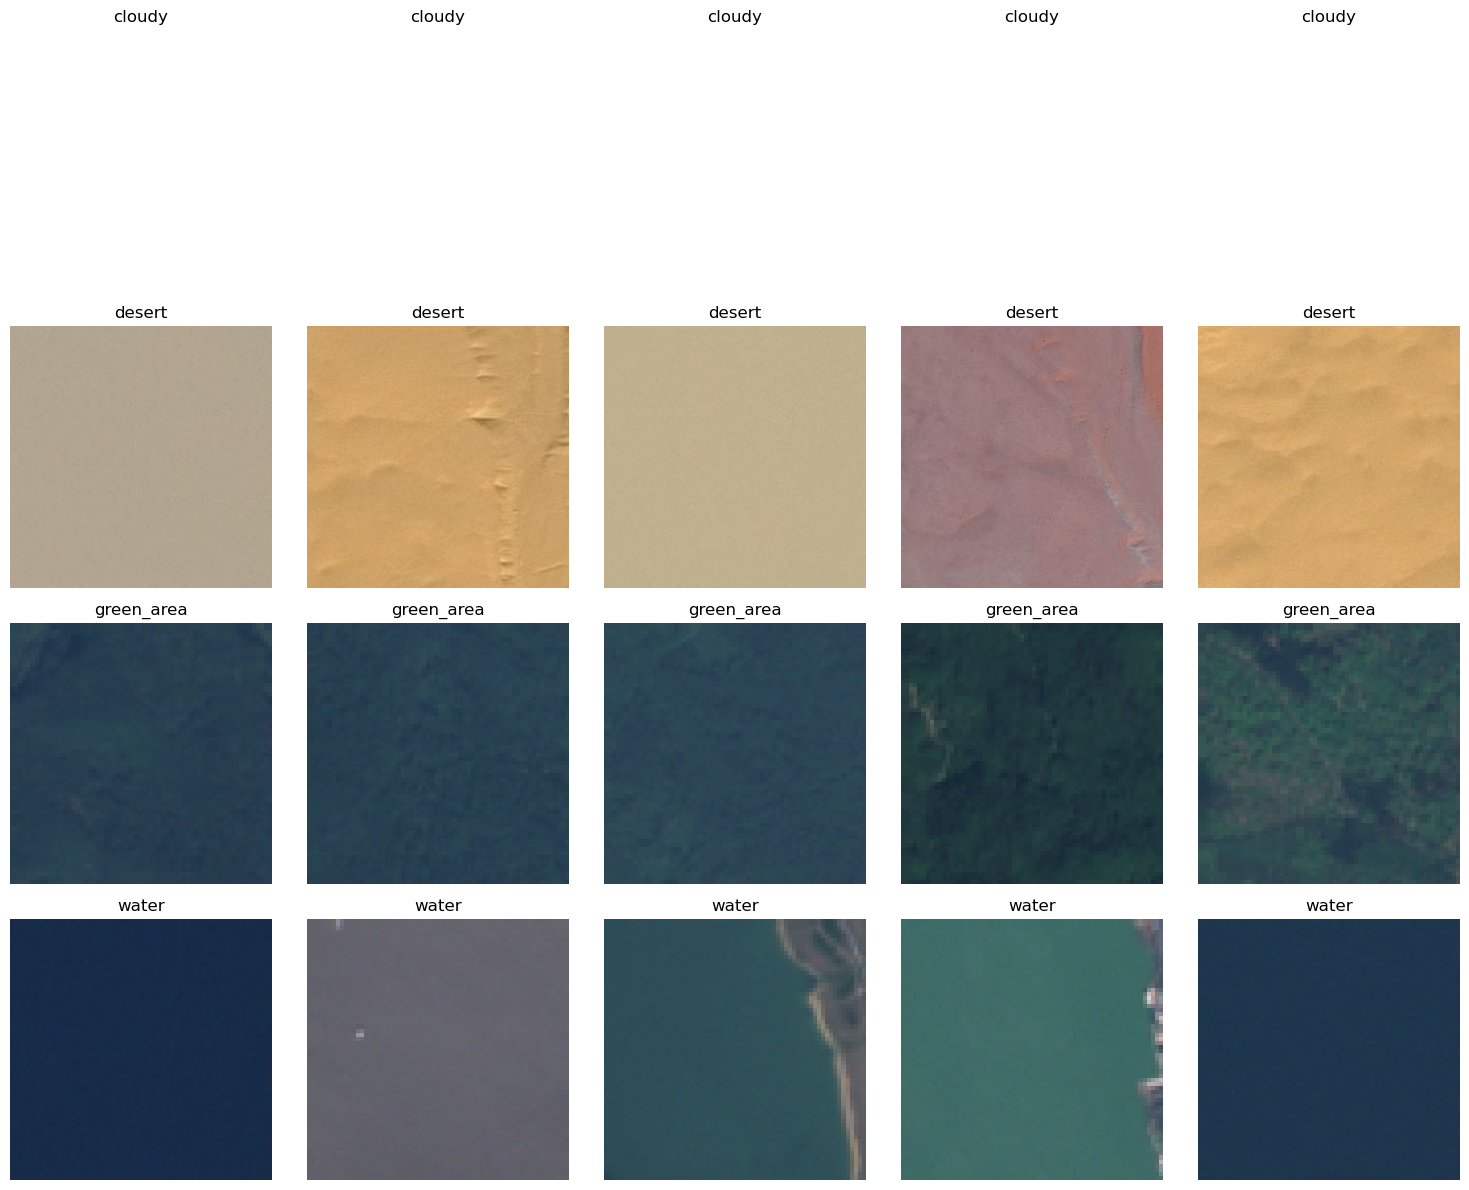

Classes trouvées: ['cloudy', 'desert', 'green_area', 'water']
Traitement de 50 images pour la classe 'cloudy'...


100%|██████████| 50/50 [00:15<00:00,  3.22it/s]


Traitement de 50 images pour la classe 'desert'...


100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


Traitement de 50 images pour la classe 'green_area'...


100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


Traitement de 50 images pour la classe 'water'...


100%|██████████| 50/50 [00:14<00:00,  3.38it/s]


Caractéristiques extraites: (200, 87)
Classes: ['cloudy', 'desert', 'green_area', 'water']
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Meilleur score de validation croisée: 0.9437
Modèle entrainé.
Précision sur l'ensemble de test: 1.0000

Rapport de classification:
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00        10
      desert       1.00      1.00      1.00        10
  green_area       1.00      1.00      1.00        10
       water       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



['terrain_classifier_model.pkl']

In [112]:
# Exploration du dataset
data_path = "data"  # Ajustez si votre dossier a un nom différent
visualize_sample_images(data_path)

# Préparation des données - limiter le nombre d'échantillons pour un premier test
X, y, class_names = prepare_dataset(data_path, sample_limit=50)

print(f"Caractéristiques extraites: {X.shape}")
print(f"Classes: {class_names}")

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entraînement du modèle
model = train_classifier(X_train, y_train)

# Évaluation du modèle
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision sur l'ensemble de test: {accuracy:.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Sauvegarder le modèle
joblib.dump(model, 'terrain_classifier_model.pkl')

## Tests et démonstration


Test sur l'image: data\cloudy\train_10021.jpg


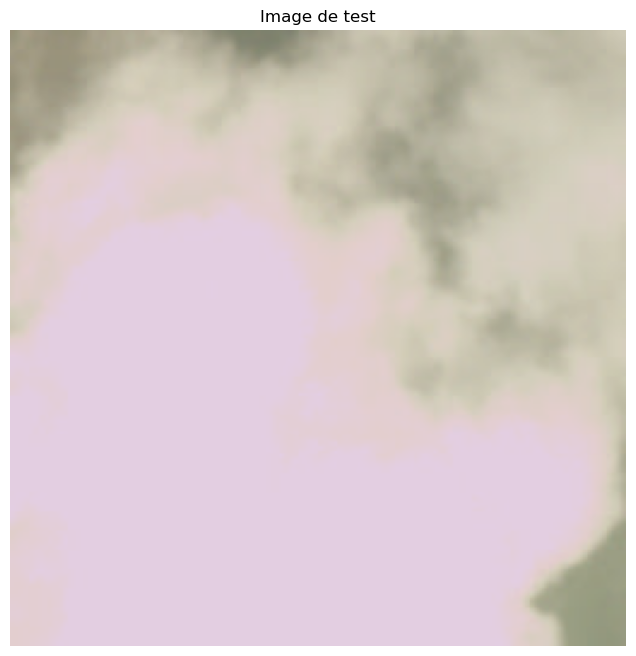

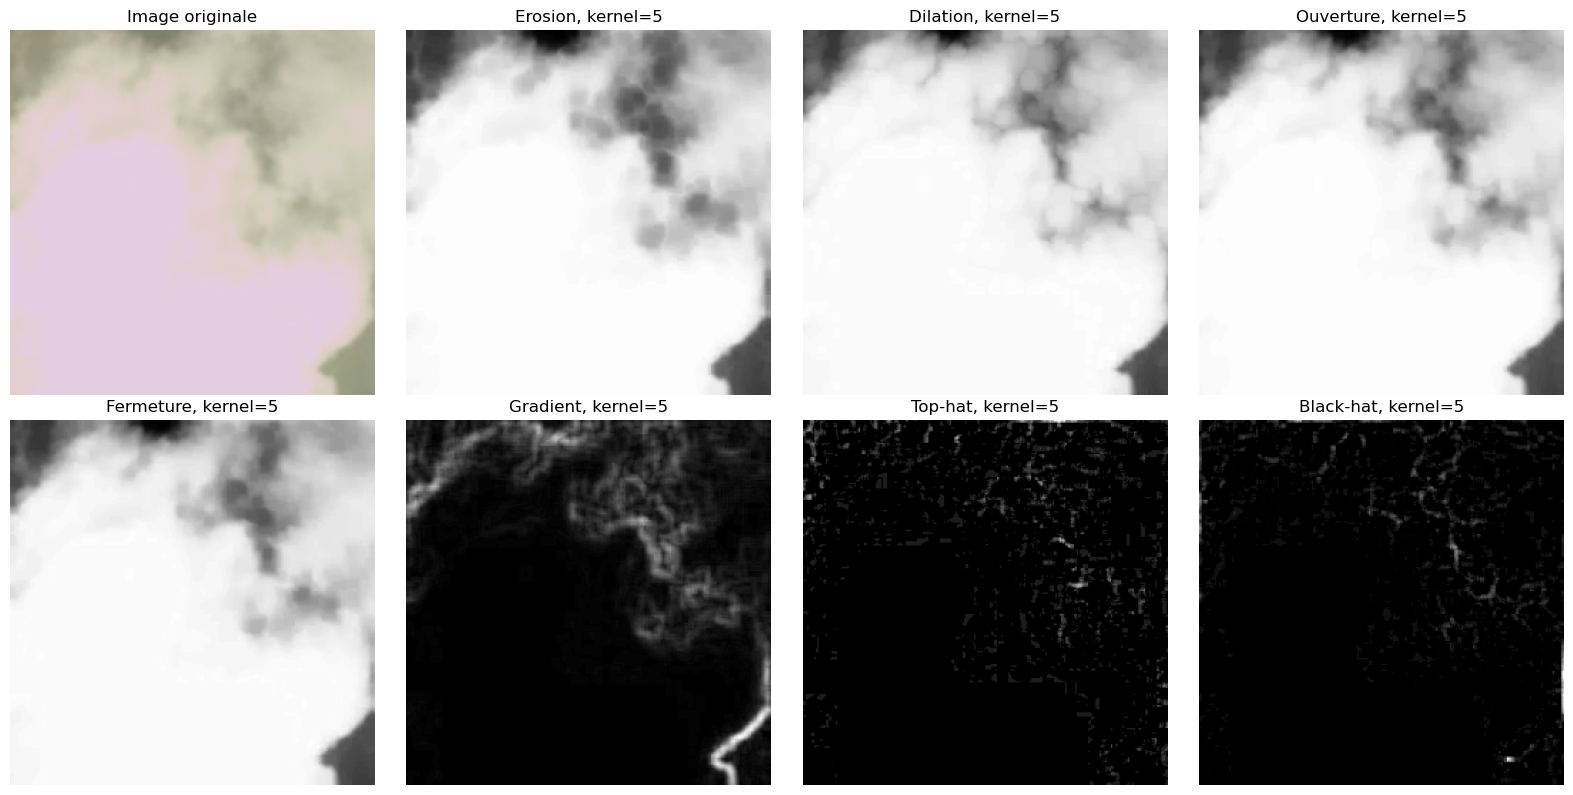

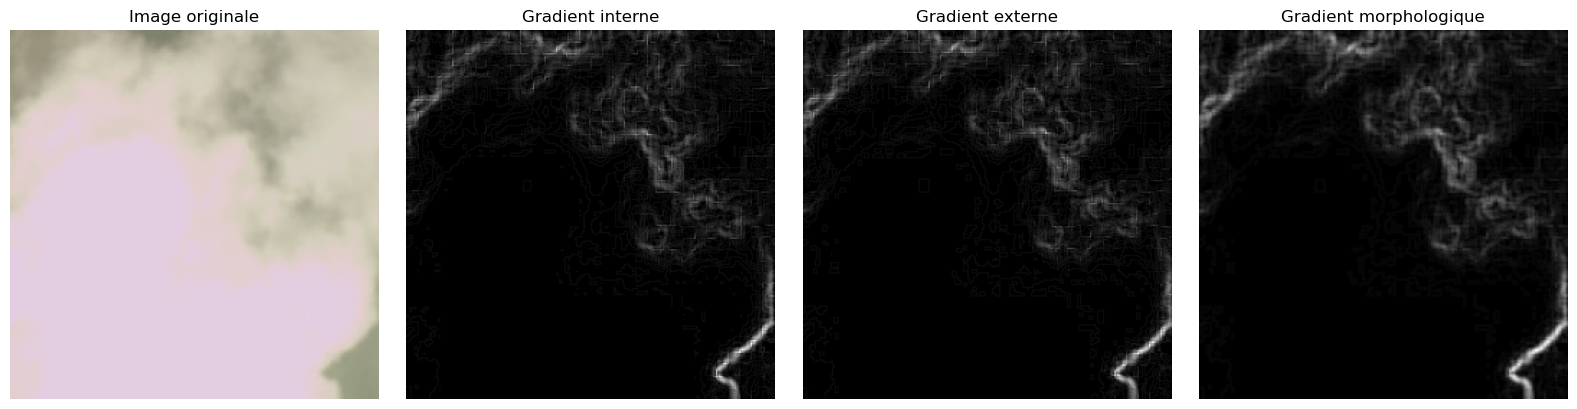

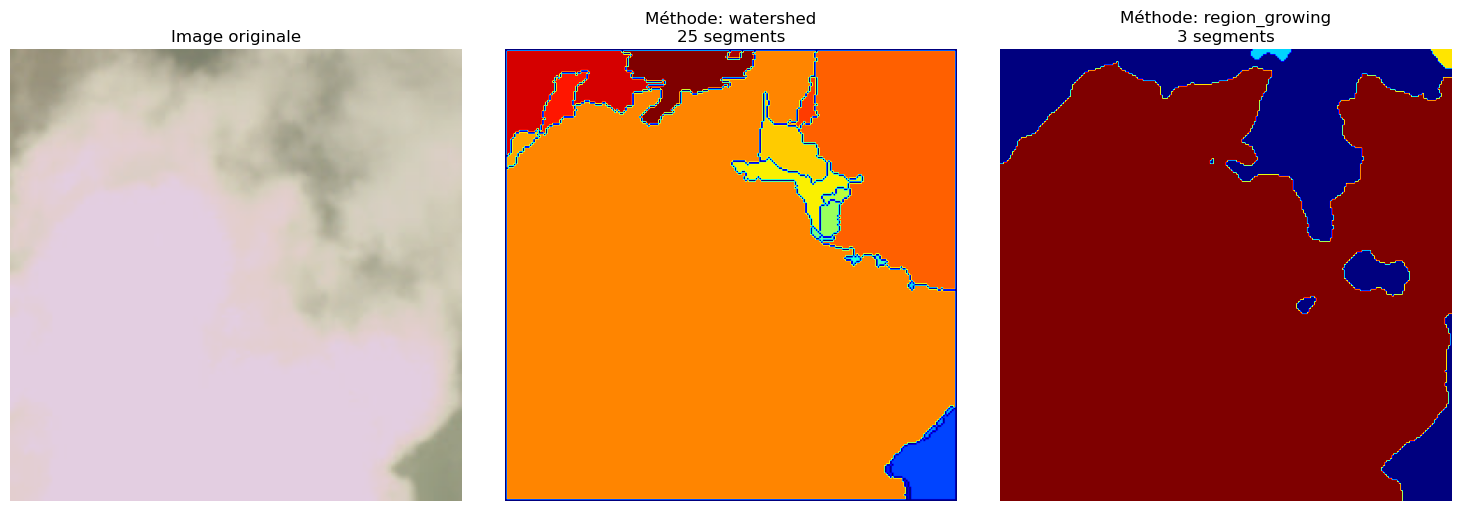

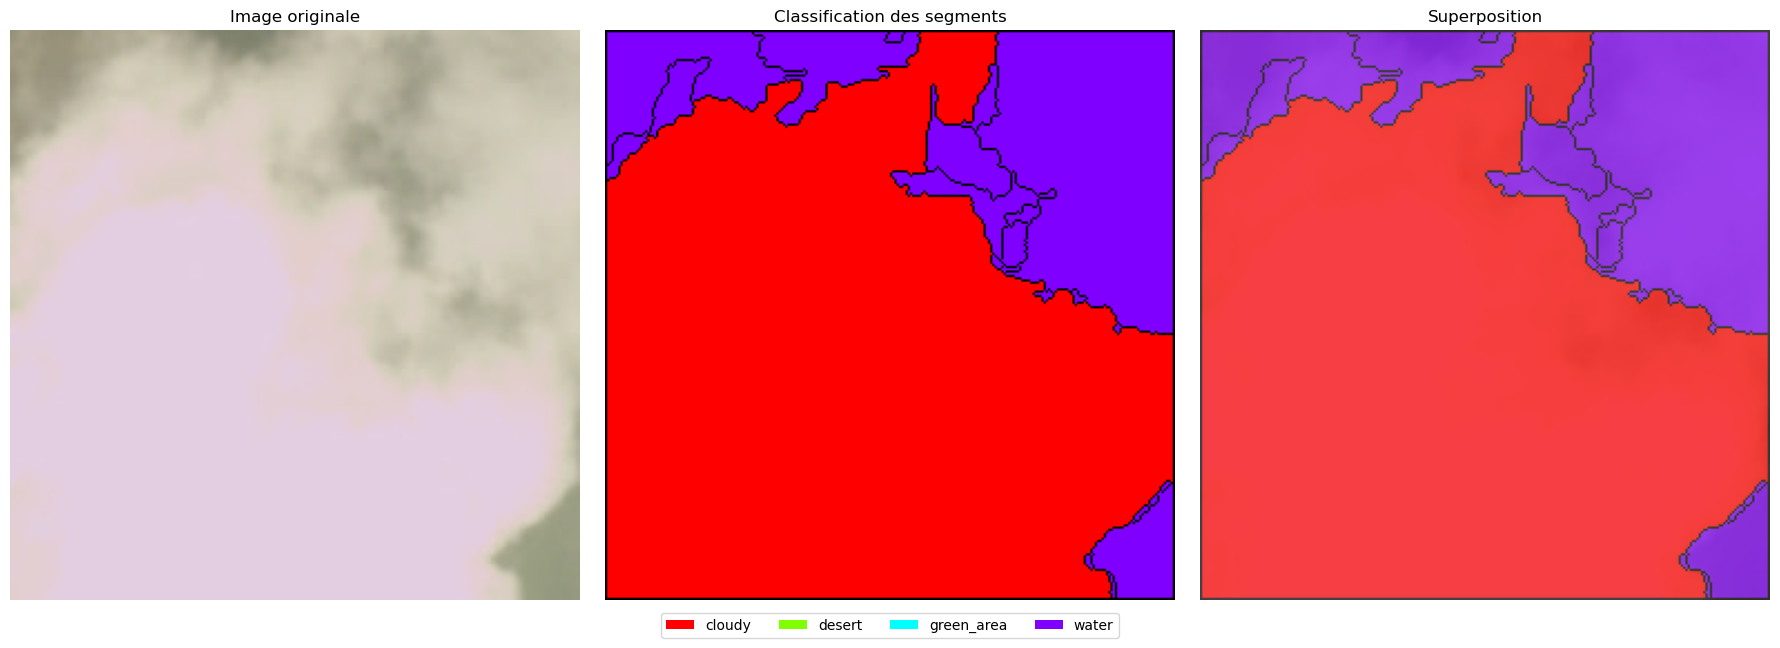

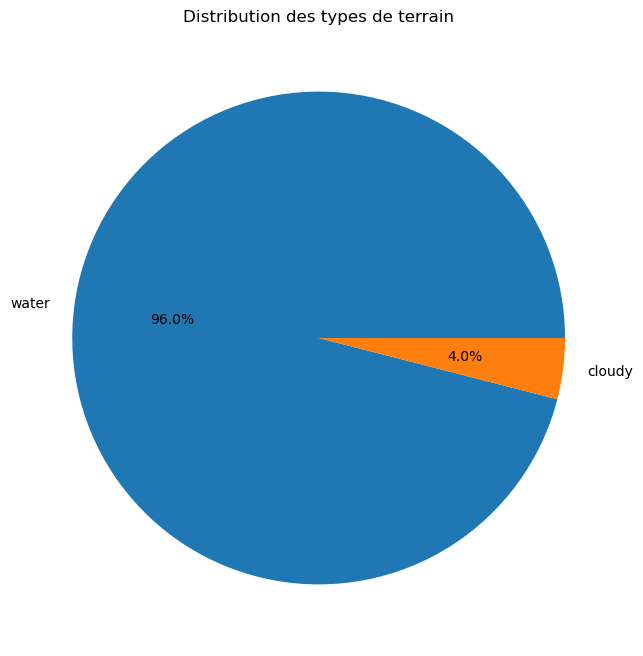


Test sur l'image: data\desert\desert(1).jpg


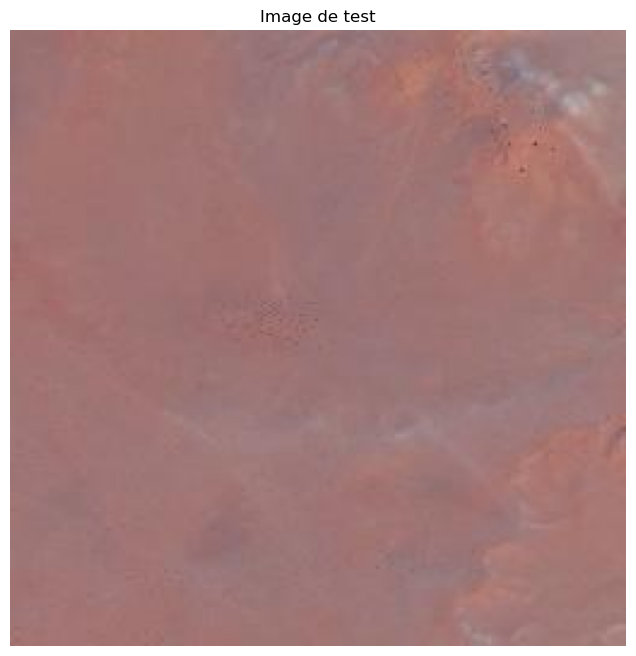

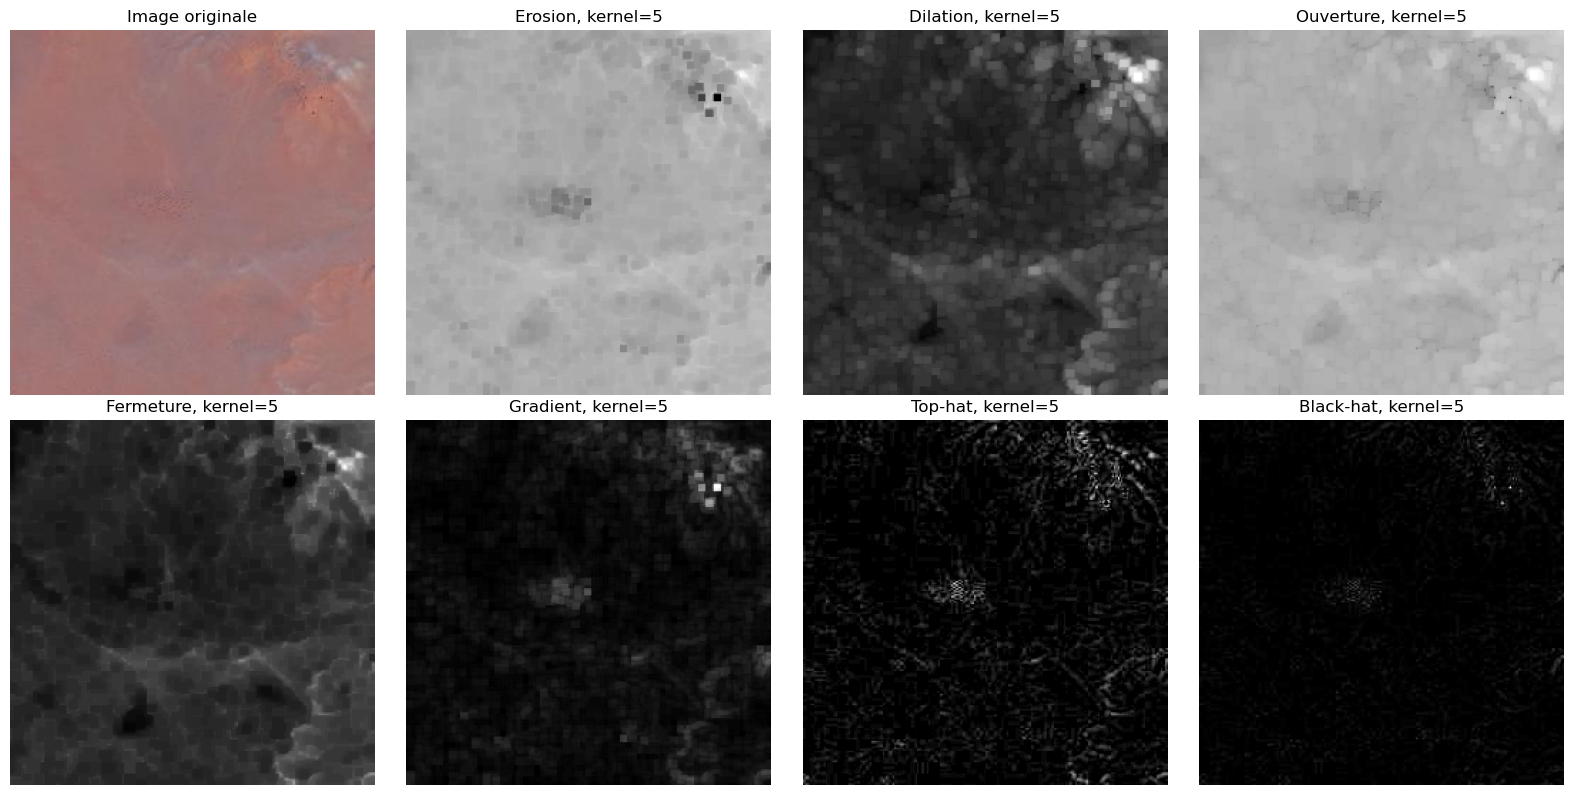

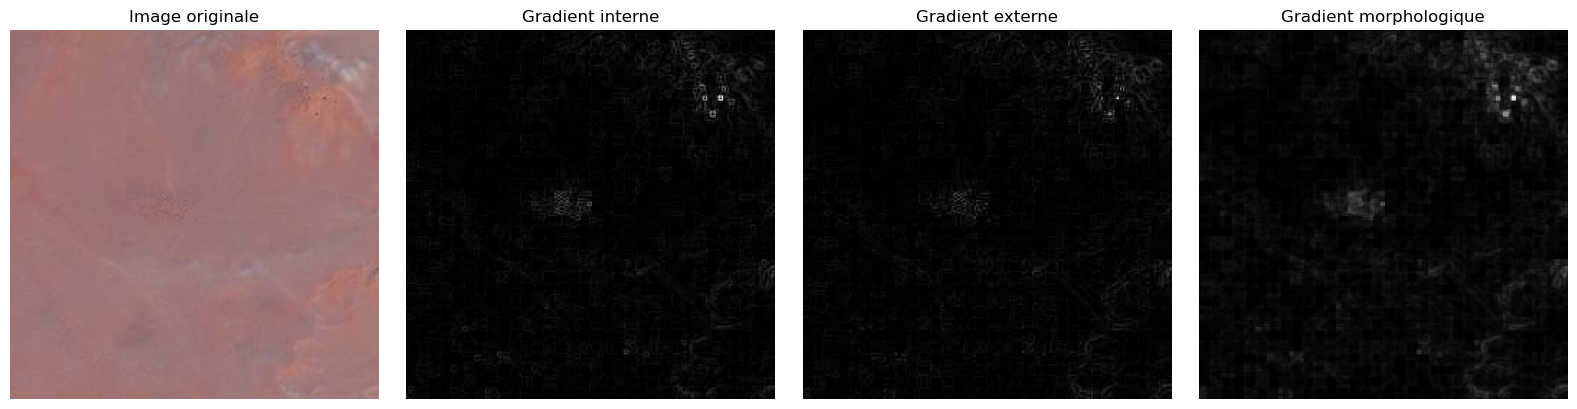

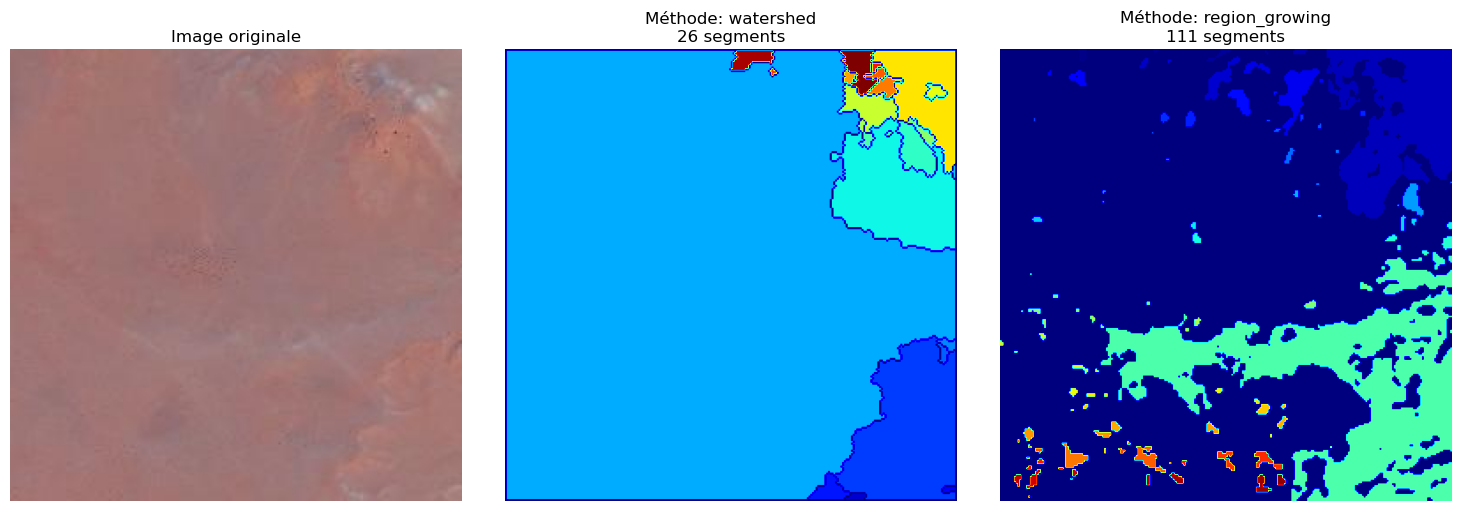

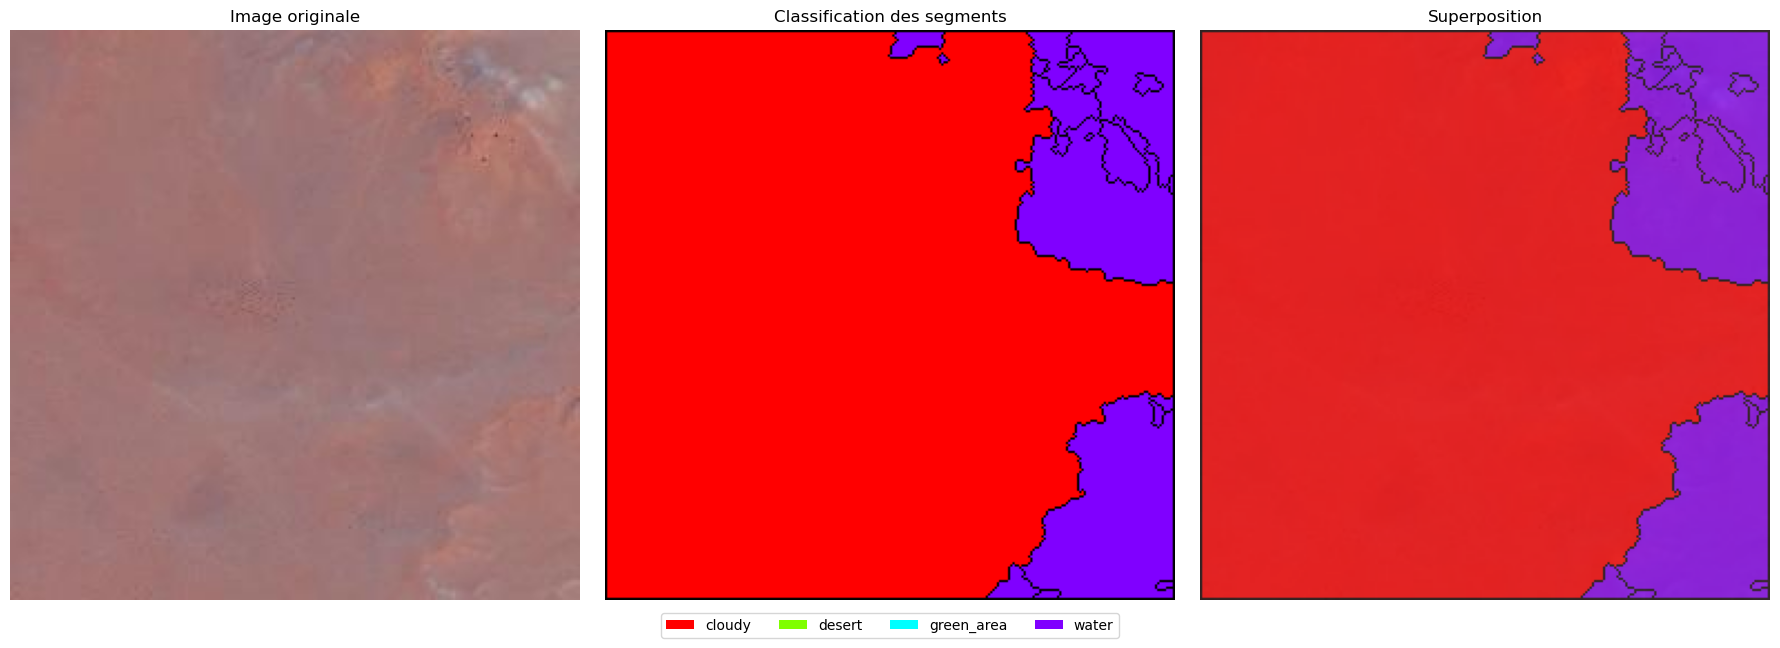

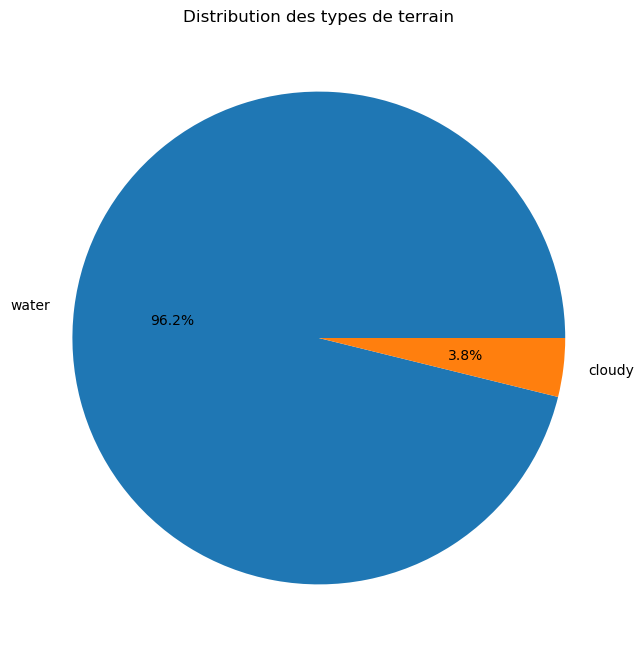


Test sur l'image: data\green_area\Forest_1404.jpg


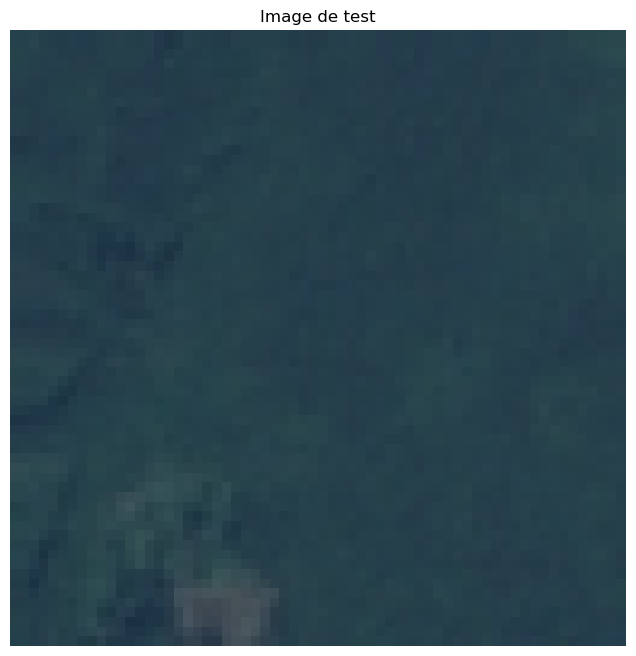

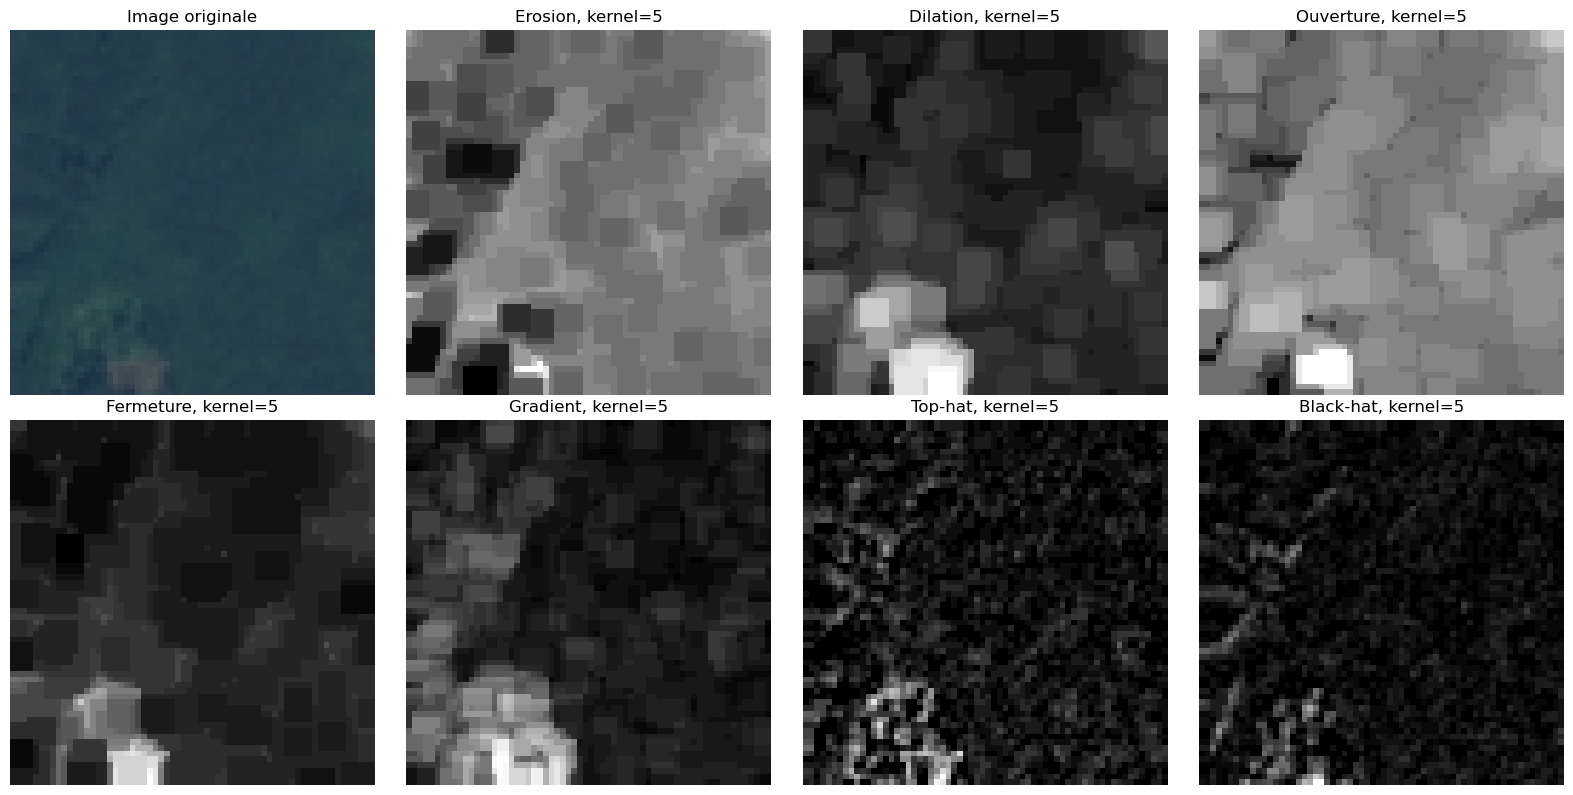

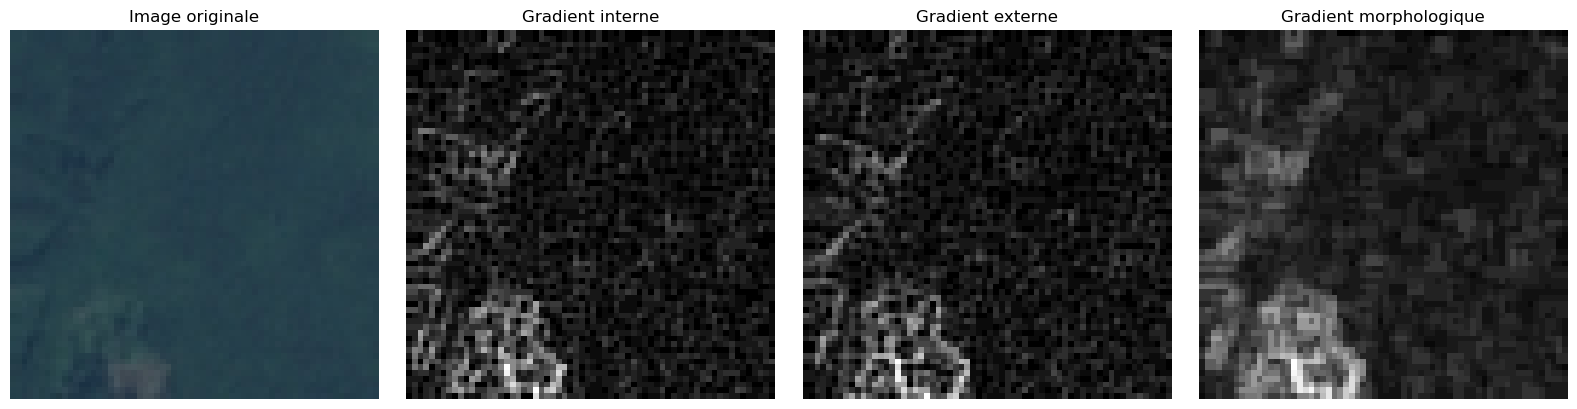

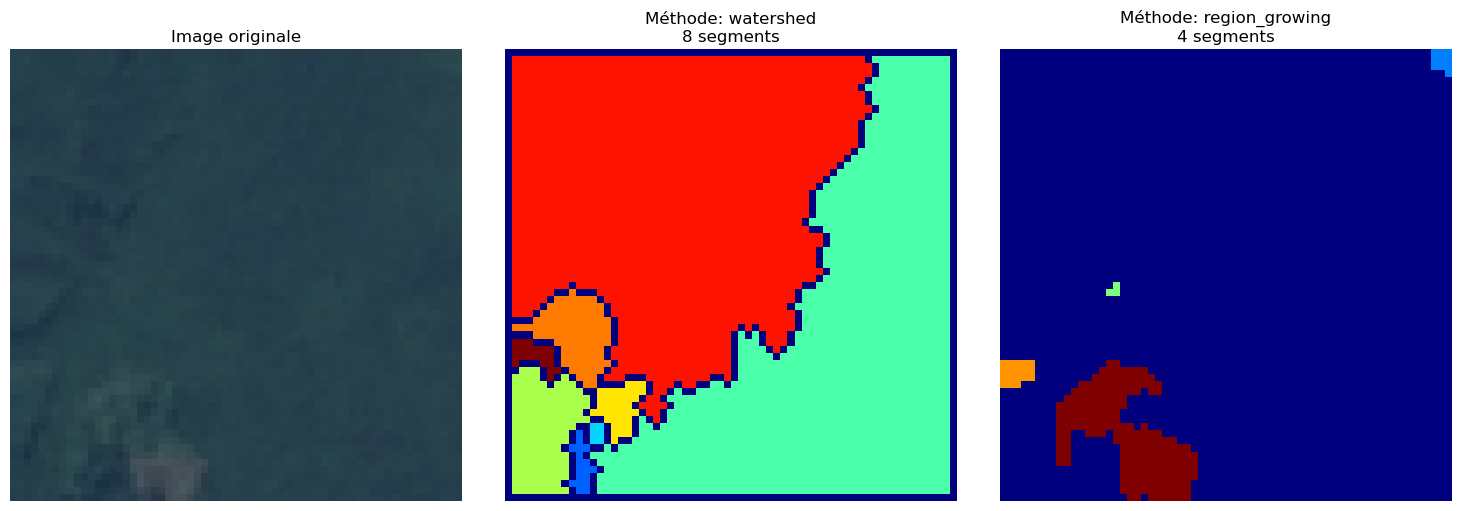

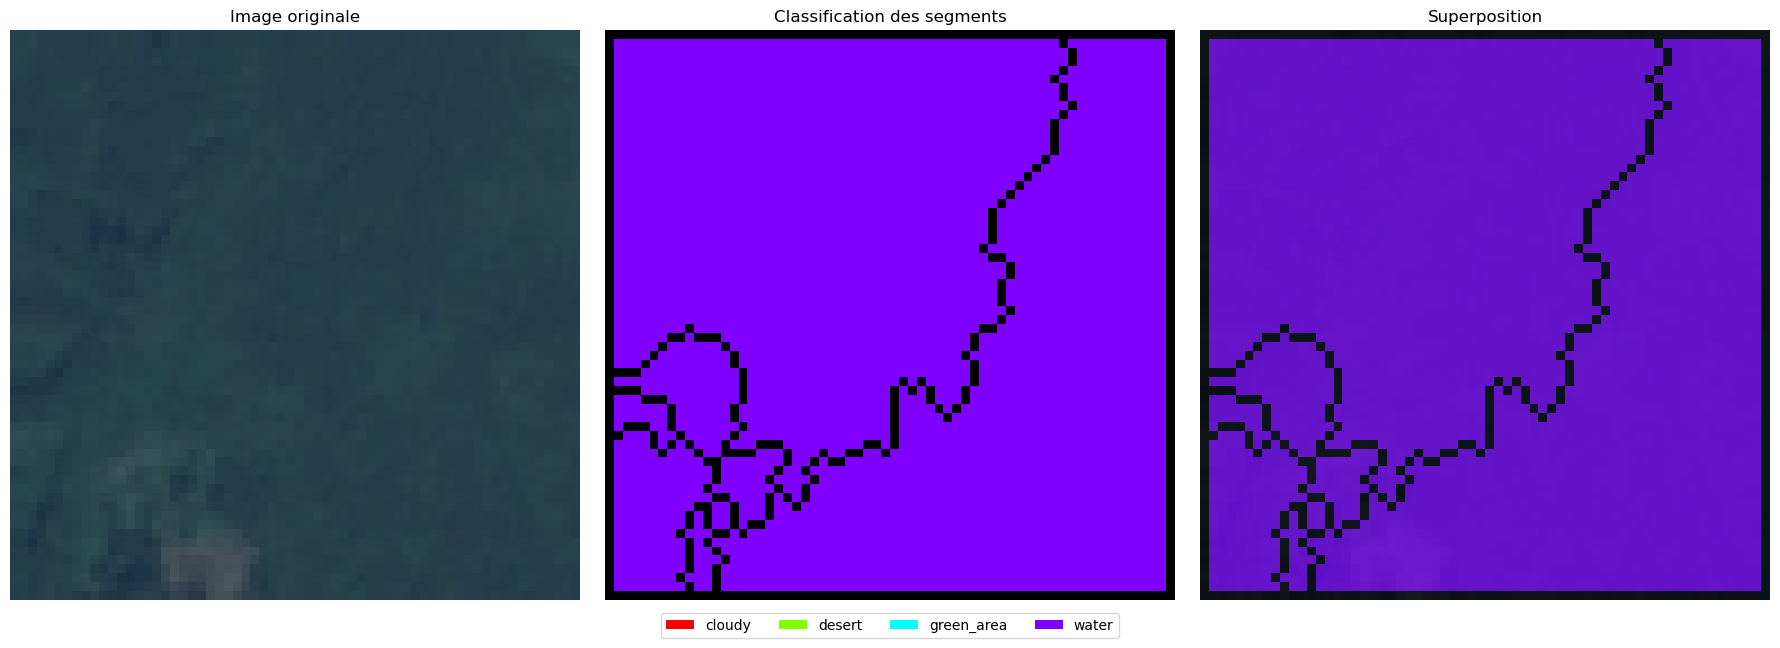

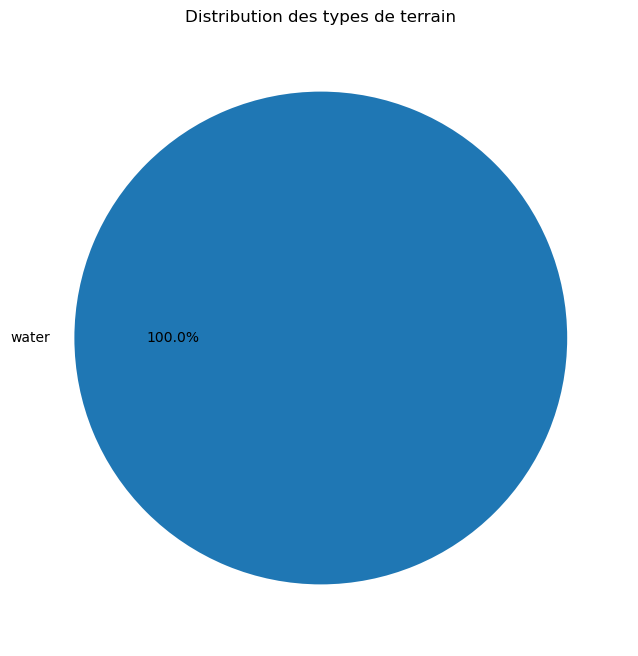

In [114]:
# Charger le modèle (s'il a été sauvegardé précédemment)
try:
    model = joblib.load('terrain_classifier_model.pkl')
except:
    print("Modèle non trouvé. Veuillez d'abord entraîner le modèle.")

# Sélectionner quelques images de test
test_images = []
for class_name in class_names:
    class_samples = glob.glob(os.path.join(data_path, class_name, '*.jpg'))
    if class_samples:
        test_images.append(class_samples[0])

# Tester le système sur les images sélectionnées
for test_image in test_images[:3]:  # Tester les 3 premières images
    print(f"\nTest sur l'image: {test_image}")
    image = cv2.imread(test_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title('Image de test')
    plt.axis('off')
    plt.show()
    
    # Visualiser les opérations morphologiques
    visualize_morphological_operations(image)
    
    # Visualiser les gradients morphologiques
    visualize_gradient_types(image)
    
    # Comparer les méthodes de segmentation
    compare_segmentation_methods(image)
    
    # Créer une carte de segmentation avec classification
    segmented, segment_classes, blended = create_segmentation_map(image, model, class_names)

## Evaluation de la ségmentation

In [116]:
def evaluate_segmentation_methods(images, methods=['watershed', 'region_growing']):
    """
    Évalue les performances des différentes méthodes de segmentation
    
    Args:
        images: Liste de chemins d'images à évaluer
        methods: Liste des méthodes à comparer
    """
    results = {method: {'n_segments': [], 'segments_median_size': []} for method in methods}
    
    for img_path in images:
        print(f"Évaluation de {img_path}")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for method in methods:
            # Mesurer le temps d'exécution
            start_time = time.time()
            labels, n_segments = segment_image_morphology(img, method=method)
            execution_time = time.time() - start_time
            
            # Calculer la taille médiane des segments
            segment_sizes = []
            for i in range(1, n_segments + 2):
                segment_size = np.sum(labels == i)
                if segment_size > 0:
                    segment_sizes.append(segment_size)
            
            median_size = np.median(segment_sizes) if segment_sizes else 0
            
            # Stocker les résultats
            results[method]['n_segments'].append(n_segments)
            results[method]['segments_median_size'].append(median_size)
            
            print(f"  Méthode {method}: {n_segments} segments, taille médiane = {median_size:.1f} pixels")
    
    # Calculer les statistiques
    for method in methods:
        avg_segments = np.mean(results[method]['n_segments'])
        avg_size = np.mean(results[method]['segments_median_size'])
        print(f"\nStatistiques pour {method}:")
        print(f"  Nombre moyen de segments: {avg_segments:.1f}")
        print(f"  Taille médiane moyenne des segments: {avg_size:.1f} pixels")
    
    # Visualiser les résultats
    plt.figure(figsize=(12, 6))
    
    # Diagramme à barres pour le nombre de segments
    plt.subplot(1, 2, 1)
    for i, method in enumerate(methods):
        plt.bar(np.arange(len(images)) + i*0.35, results[method]['n_segments'], width=0.35, 
                label=method, alpha=0.7)
    
    plt.xlabel('Images')
    plt.ylabel('Nombre de segments')
    plt.title('Nombre de segments par méthode')
    plt.legend()
    plt.xticks(np.arange(len(images)), [os.path.basename(img) for img in images], rotation=45)
    
    # Diagramme à barres pour la taille médiane des segments
    plt.subplot(1, 2, 2)
    for i, method in enumerate(methods):
        plt.bar(np.arange(len(images)) + i*0.35, results[method]['segments_median_size'], width=0.35, 
                label=method, alpha=0.7)
    
    plt.xlabel('Images')
    plt.ylabel('Taille médiane des segments (pixels)')
    plt.title('Taille médiane des segments par méthode')
    plt.legend()
    plt.xticks(np.arange(len(images)), [os.path.basename(img) for img in images], rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results

## Analyse des textures 

In [118]:
def analyze_texture_features(image):
    """
    Analyse les caractéristiques de texture d'une image et les visualise
    
    Args:
        image: Image à analyser
    """
    # Extraire les caractéristiques
    features = extract_texture_features(image)
    
    # Convertir en niveaux de gris si nécessaire
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Calculer les matrices GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances, angles, 256, symmetric=True, normed=True)
    
    # Calculer les propriétés GLCM pour visualisation
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    
    # Calculer LBP
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    
    # Visualiser
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Image originale
    axes[0, 0].imshow(image if len(image.shape) > 2 else gray, cmap='gray' if len(image.shape) == 2 else None)
    axes[0, 0].set_title('Image originale')
    axes[0, 0].axis('off')
    
    # LBP
    axes[0, 1].imshow(lbp, cmap='gray')
    axes[0, 1].set_title('Local Binary Pattern')
    axes[0, 1].axis('off')
    
    # Histogramme LBP
    hist_lbp, _ = np.histogram(lbp, bins=10, range=(0, 10))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-6)
    axes[0, 2].bar(range(10), hist_lbp)
    axes[0, 2].set_title('Histogramme LBP')
    axes[0, 2].set_xlabel('Bins')
    axes[0, 2].set_ylabel('Fréquence normalisée')
    
    # Propriétés GLCM en fonction de la distance
    x = distances
    axes[1, 0].plot(x, contrast.mean(axis=1), 'o-', label='Contraste')
    axes[1, 0].plot(x, dissimilarity.mean(axis=1), 's-', label='Dissimilarité')
    axes[1, 0].plot(x, homogeneity.mean(axis=1), '^-', label='Homogénéité')
    axes[1, 0].set_title('Propriétés GLCM vs Distance')
    axes[1, 0].set_xlabel('Distance')
    axes[1, 0].set_ylabel('Valeur')
    axes[1, 0].legend()
    
    # Propriétés GLCM en fonction de l'angle
    x = [0, 45, 90, 135]  # Angles en degrés pour l'affichage
    axes[1, 1].plot(x, contrast.mean(axis=0), 'o-', label='Contraste')
    axes[1, 1].plot(x, dissimilarity.mean(axis=0), 's-', label='Dissimilarité')
    axes[1, 1].plot(x, homogeneity.mean(axis=0), '^-', label='Homogénéité')
    axes[1, 1].set_title('Propriétés GLCM vs Angle')
    axes[1, 1].set_xlabel('Angle (degrés)')
    axes[1, 1].set_ylabel('Valeur')
    axes[1, 1].legend()
    
    # Caractéristiques d'Haralick
    haralick = mh.features.haralick(gray).mean(axis=0)
    axes[1, 2].bar(range(len(haralick)), haralick)
    axes[1, 2].set_title('Caractéristiques de Haralick')
    axes[1, 2].set_xlabel('Index de caractéristique')
    axes[1, 2].set_ylabel('Valeur')
    
    plt.tight_layout()
    plt.show()
    
    return features

## Importance des caractéristiques

In [120]:
def analyze_feature_importance(model, feature_names=None):
    """
    Analyse et visualise l'importance des caractéristiques du modèle RandomForest
    
    Args:
        model: Modèle entraîné (avec RandomForestClassifier)
        feature_names: Noms des caractéristiques (optionnel)
    """
    # Vérifier si le modèle est un pipeline
    if hasattr(model, 'named_steps') and 'classifier' in model.named_steps:
        classifier = model.named_steps['classifier']
    else:
        classifier = model
    
    # Vérifier si c'est un RandomForest
    if not hasattr(classifier, 'feature_importances_'):
        print("Le modèle n'est pas un RandomForest ou n'a pas d'attribut 'feature_importances_'")
        return
    
    # Obtenir l'importance des caractéristiques
    importances = classifier.feature_importances_
    
    # Créer des noms de caractéristiques par défaut si non spécifiés
    if feature_names is None:
        # Caractéristiques GLCM
        glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        distances = [1, 2, 3]
        angles = [0, 45, 90, 135]
        glcm_features = [f"{prop}_d{d}_a{a}" for prop in glcm_props 
                         for d in distances for a in angles]
        
        # Caractéristiques statistiques
        stat_features = ['mean', 'std', 'mean_gradient', 'std_gradient']
        
        # Caractéristiques Haralick (13 caractéristiques)
        haralick_features = [f'haralick_{i}' for i in range(13)]
        
        # Caractéristiques LBP (10 bins d'histogramme)
        lbp_features = [f'lbp_bin_{i}' for i in range(10)]
        
        feature_names = glcm_features + stat_features + haralick_features + lbp_features
    
    # Trier les caractéristiques par importance
    indices = np.argsort(importances)[::-1]
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(12, 8))
    
    # Montrer les 20 caractéristiques les plus importantes
    n_features = min(20, len(importances))
    plt.barh(range(n_features), importances[indices[:n_features]], align='center')
    plt.yticks(range(n_features), [feature_names[i] for i in indices[:n_features]])
    plt.xlabel('Importance')
    plt.ylabel('Caractéristique')
    plt.title('Importance des caractéristiques')
    plt.tight_layout()
    plt.show()
    
    # Retourner les importances triées
    top_features = [(feature_names[i], importances[i]) for i in indices[:n_features]]
    return top_features

In [121]:
def analyze_satellite_image(image_path, model, class_names):
    """
    Effectue une analyse complète d'une image satellite
    
    Args:
        image_path: Chemin vers l'image à analyser
        model: Modèle de classification entraîné
        class_names: Noms des classes
    """
    print(f"Analyse de l'image: {image_path}")
    
    # Charger et prétraiter l'image
    image = load_and_process_image(image_path)
    
    # Afficher l'image originale
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title('Image satellite')
    plt.axis('off')
    plt.show()
    
    # 1. Appliquer et visualiser les opérations morphologiques
    print("\n1. Opérations morphologiques")
    visualize_morphological_operations(image)
    
    # 2. Analyser les gradients morphologiques
    print("\n2. Gradients morphologiques")
    visualize_gradient_types(image)
    
    # 3. Comparer les méthodes de segmentation
    print("\n3. Comparaison des méthodes de segmentation")
    compare_segmentation_methods(image)
    
    # 4. Analyser les caractéristiques de texture
    print("\n4. Analyse des textures")
    features = analyze_texture_features(image)
    
    # 5. Créer une carte de segmentation avec classification
    print("\n5. Segmentation et classification")
    segmented, segment_classes, blended = create_segmentation_map(image, model, class_names)
    
    # 6. Afficher un résumé des résultats
    print("\n6. Résumé des résultats")
    class_distribution = {}
    for class_name in segment_classes.values():
        if class_name in class_distribution:
            class_distribution[class_name] += 1
        else:
            class_distribution[class_name] = 1
    
    print("Distribution des types de terrain:")
    for class_name, count in class_distribution.items():
        percentage = count / len(segment_classes) * 100
        print(f"  {class_name}: {count} segments ({percentage:.1f}%)")
    
    return segmented, segment_classes, blended

In [122]:
def load_and_process_image(image_path):
    """
    Charge et prétraite une image pour l'analyse
    
    Args:
        image_path: Chemin vers l'image à charger
        
    Returns:
        Image prétraitée
    """
    # Charger l'image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Redimensionner si l'image est trop grande
    max_dim = 1024
    h, w = image.shape[:2]
    if max(h, w) > max_dim:
        if h > w:
            new_h, new_w = max_dim, int(w * max_dim / h)
        else:
            new_h, new_w = int(h * max_dim / w), max_dim
        image = cv2.resize(image, (new_w, new_h))
    
    return image

ANALYSE DE TEXTURES ET SEGMENTATION D'IMAGES SATELLITAIRES

1. Exploration du dataset


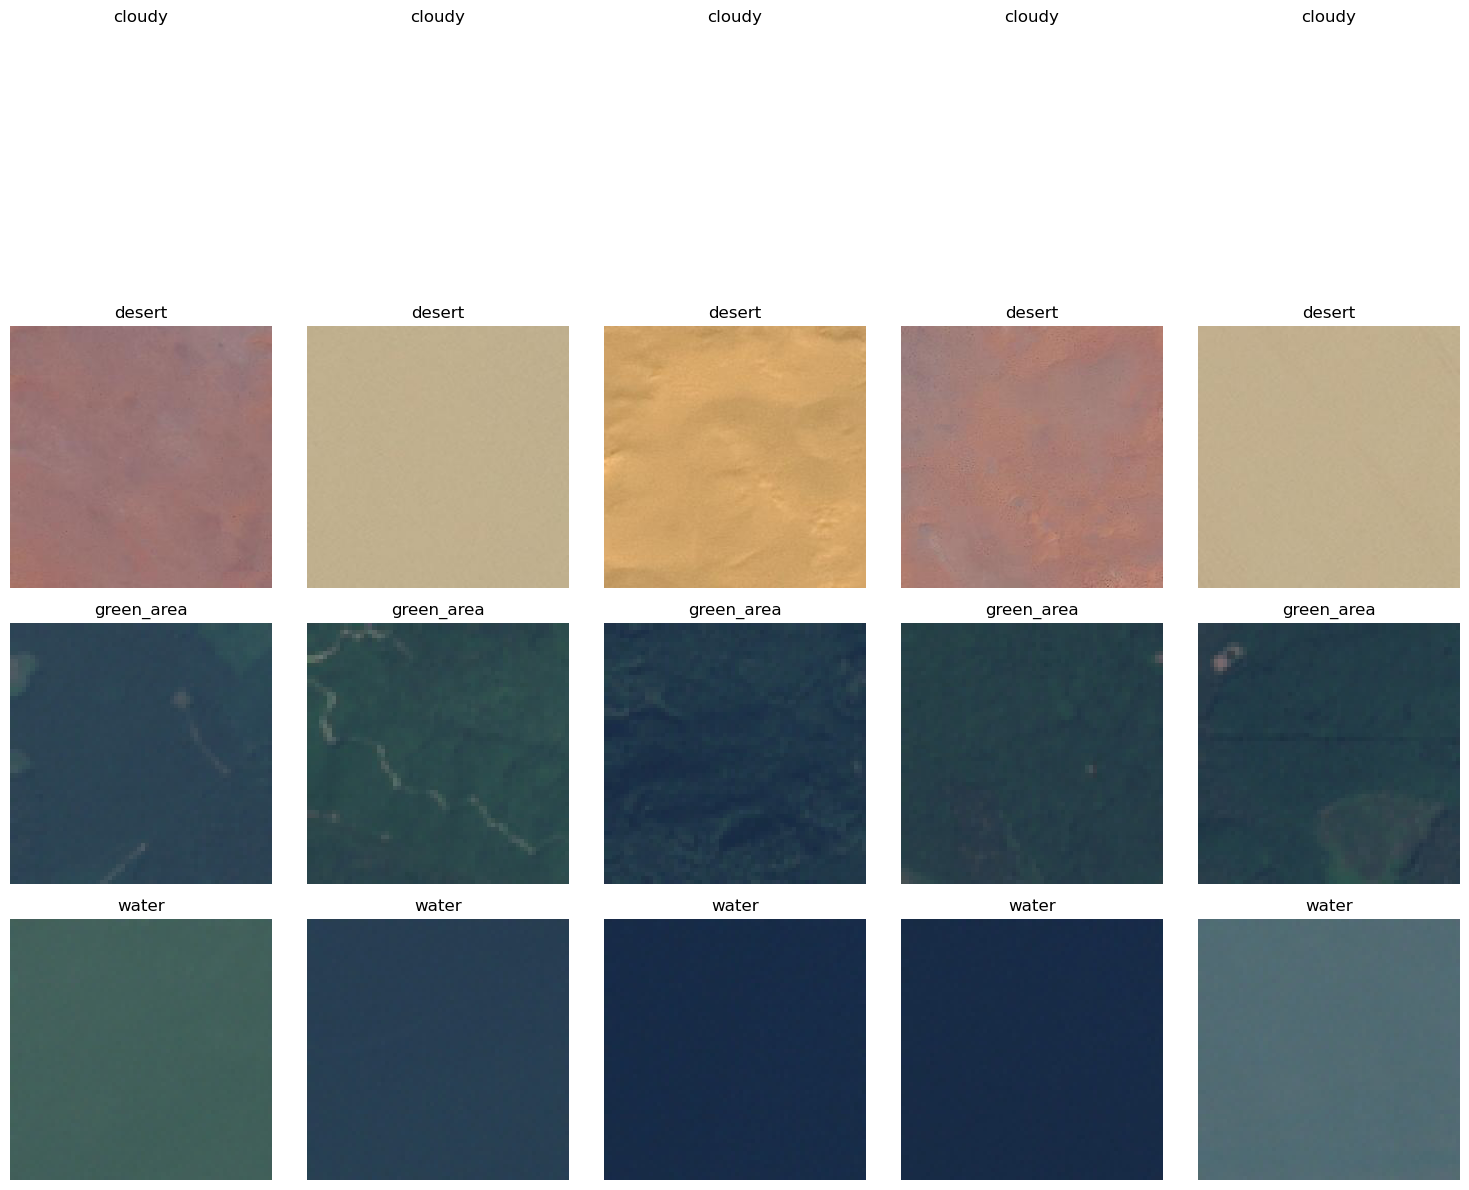


2. Extraction des caractéristiques et entraînement du modèle
Chargement du modèle préentraîné...
Classes détectées: ['cloudy', 'desert', 'green_area', 'water']

3. Analyse de l'importance des caractéristiques


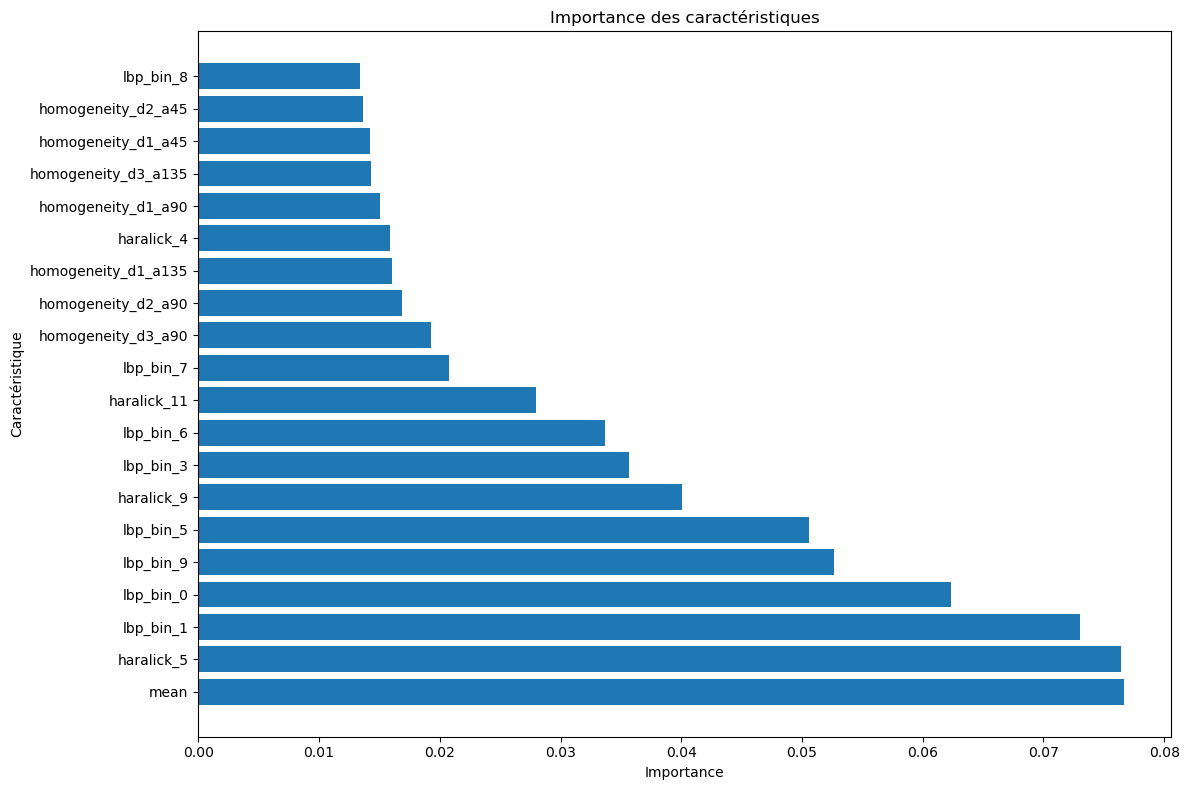


4. Analyse d'images de test
Analyse de l'image: data\cloudy\train_10021.jpg


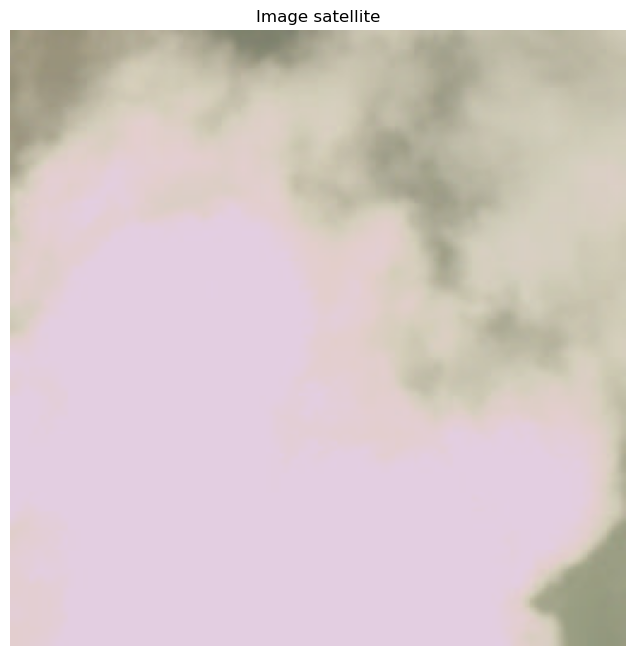


1. Opérations morphologiques


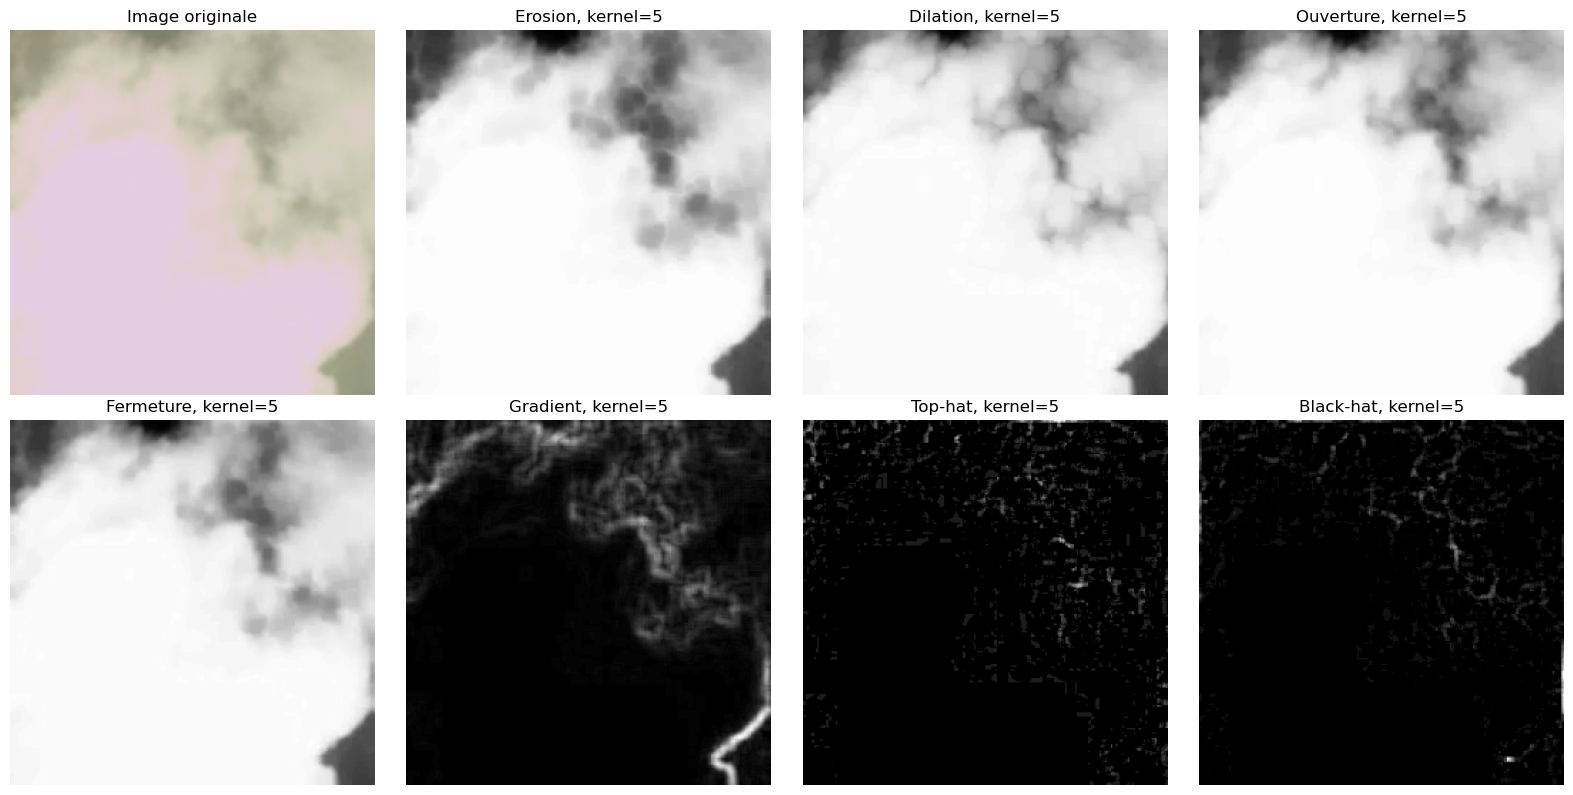


2. Gradients morphologiques


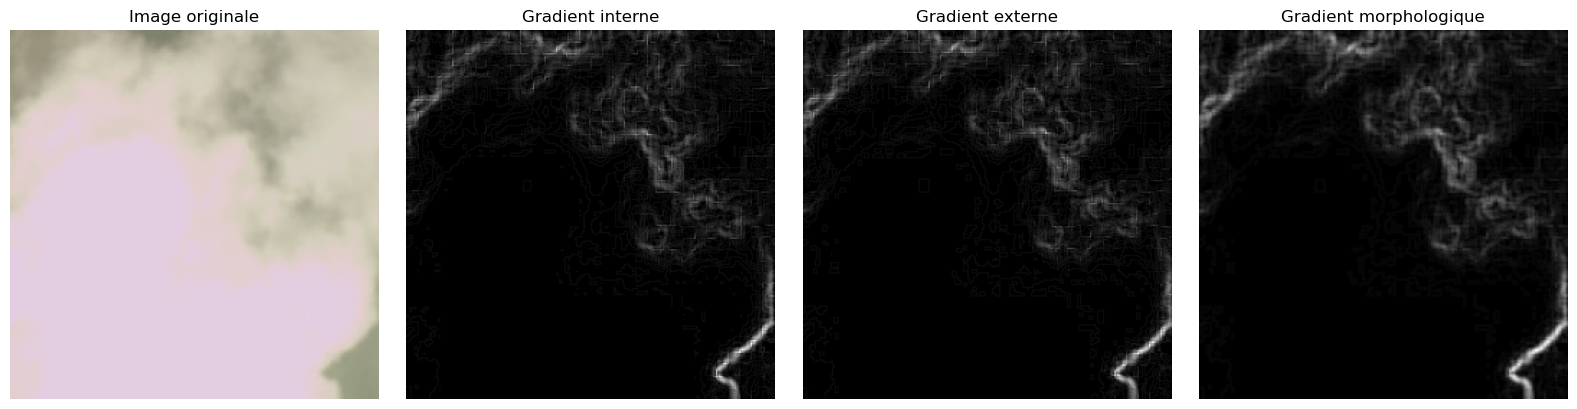


3. Comparaison des méthodes de segmentation


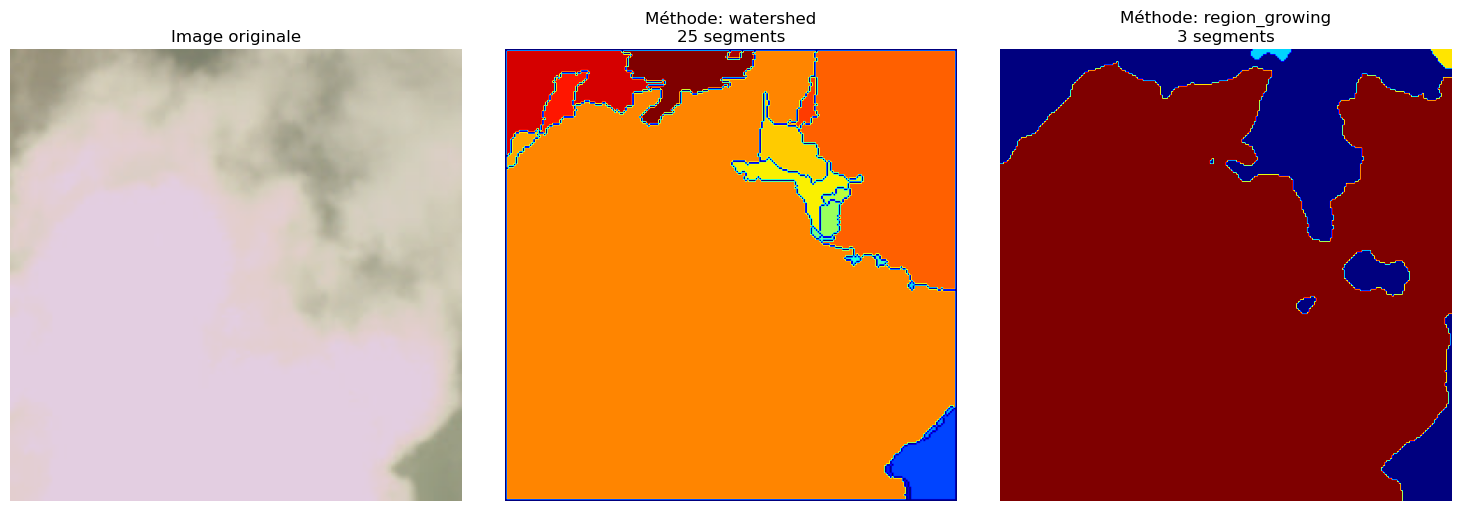


4. Analyse des textures


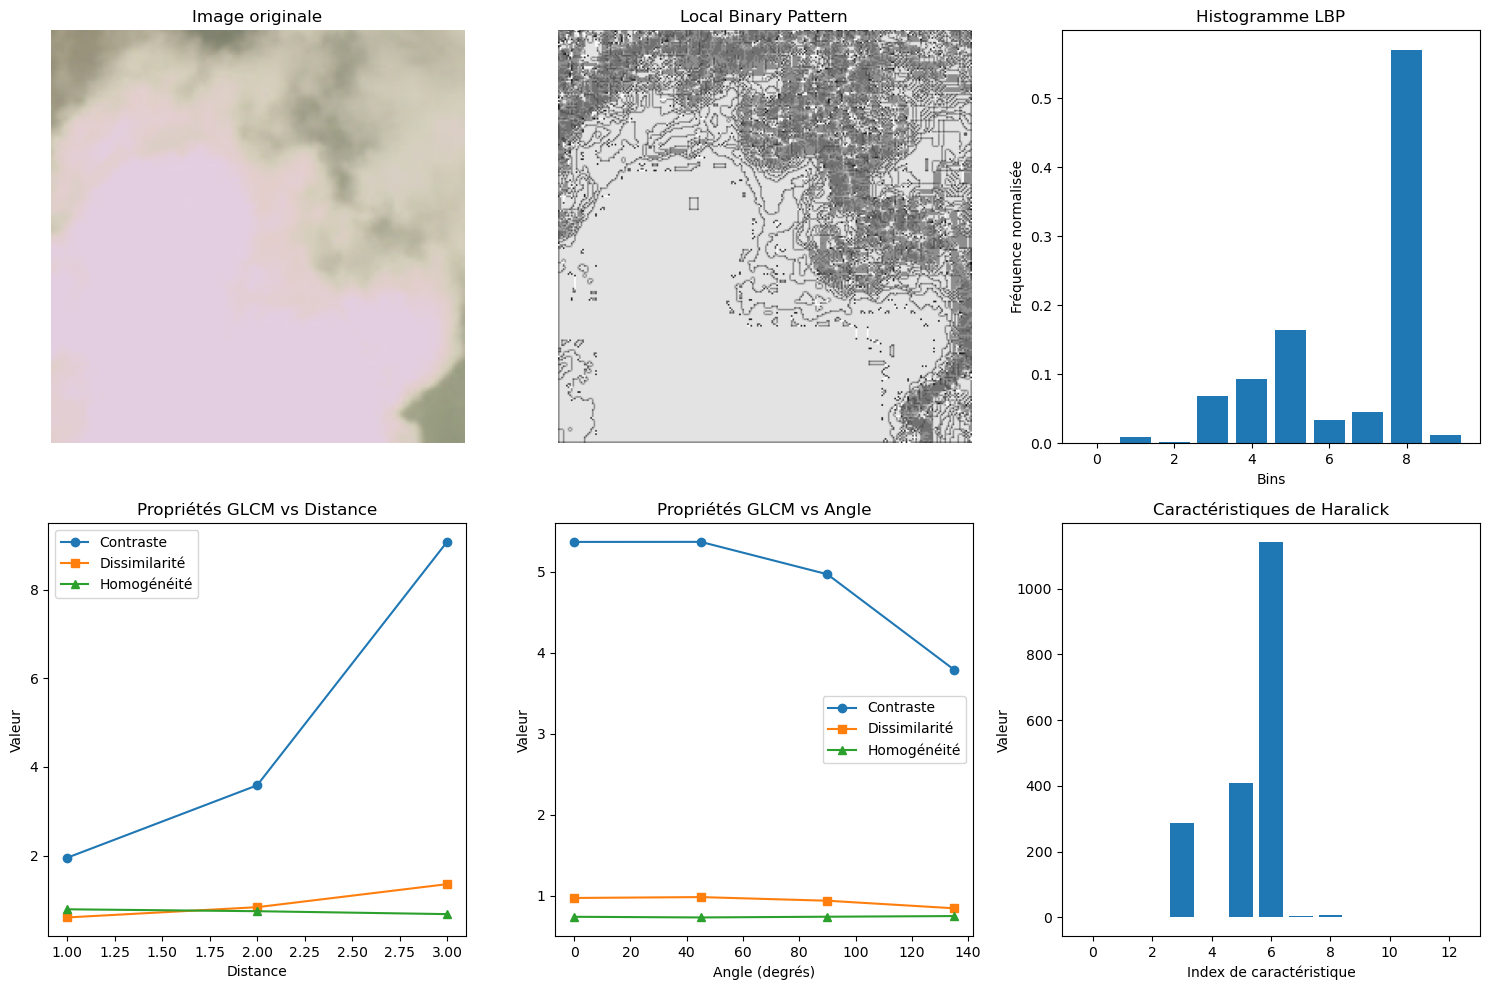


5. Segmentation et classification


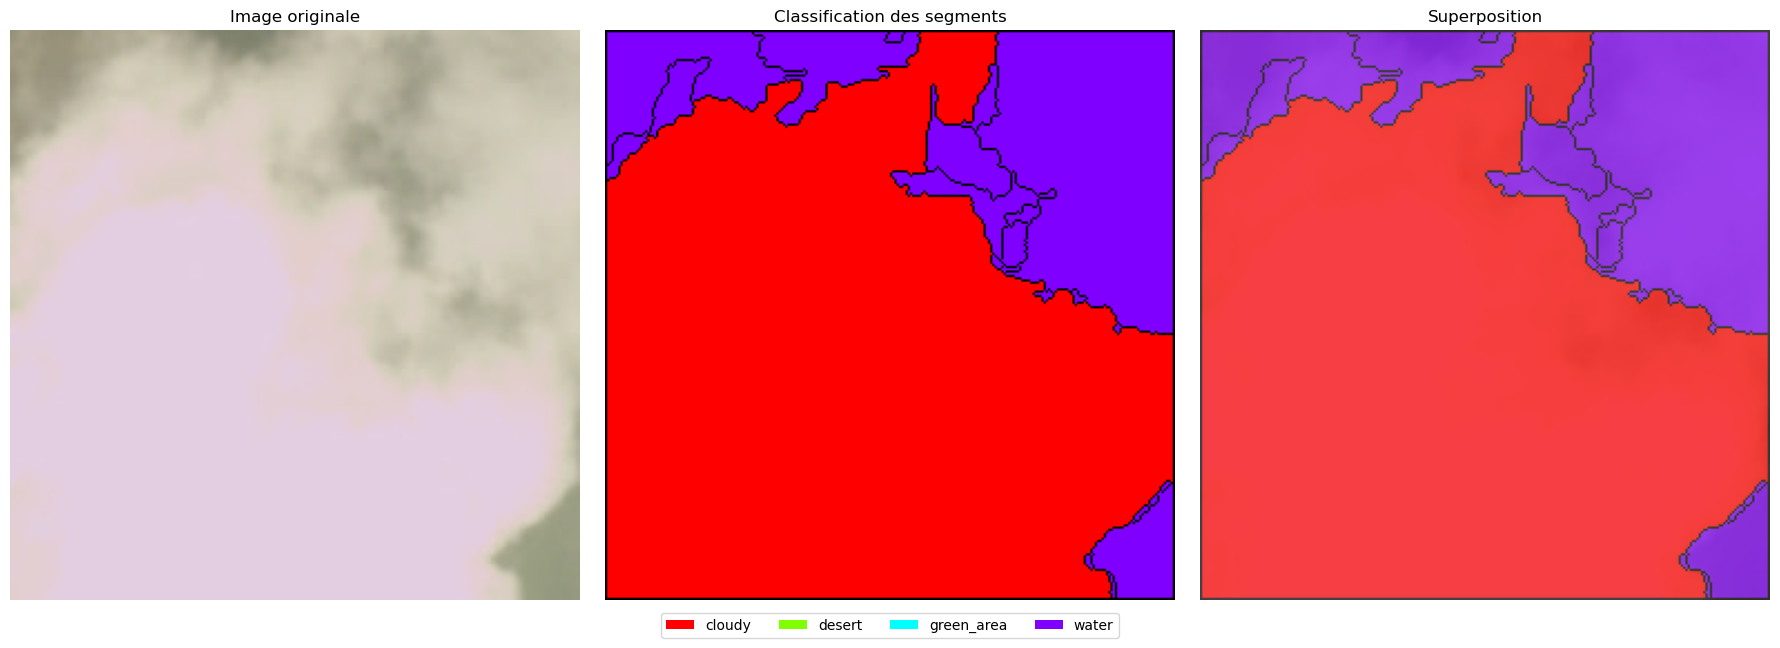

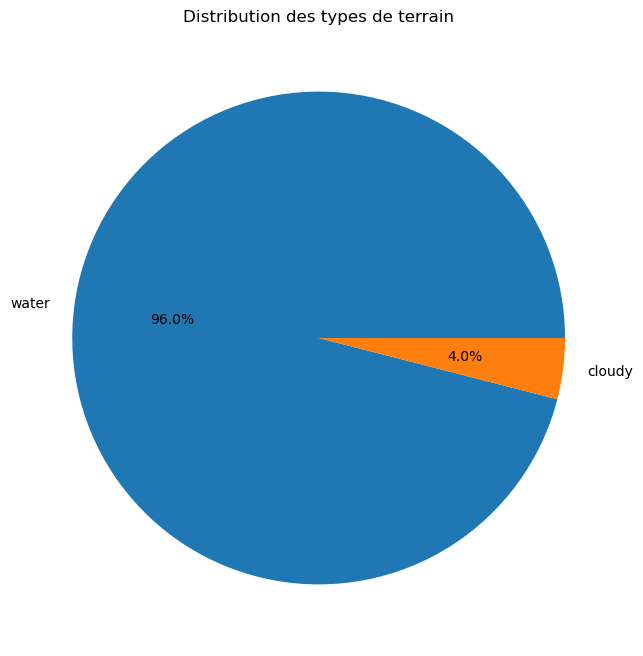


6. Résumé des résultats
Distribution des types de terrain:
  water: 24 segments (96.0%)
  cloudy: 1 segments (4.0%)
Analyse de l'image: data\desert\desert(1).jpg


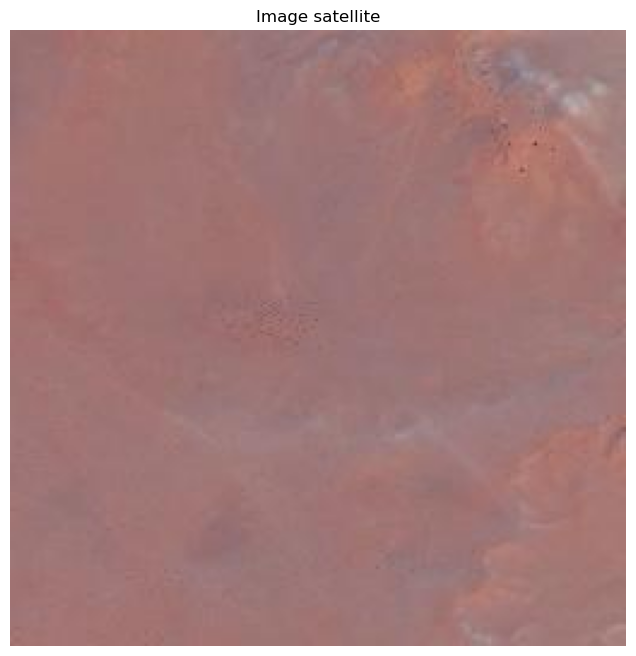


1. Opérations morphologiques


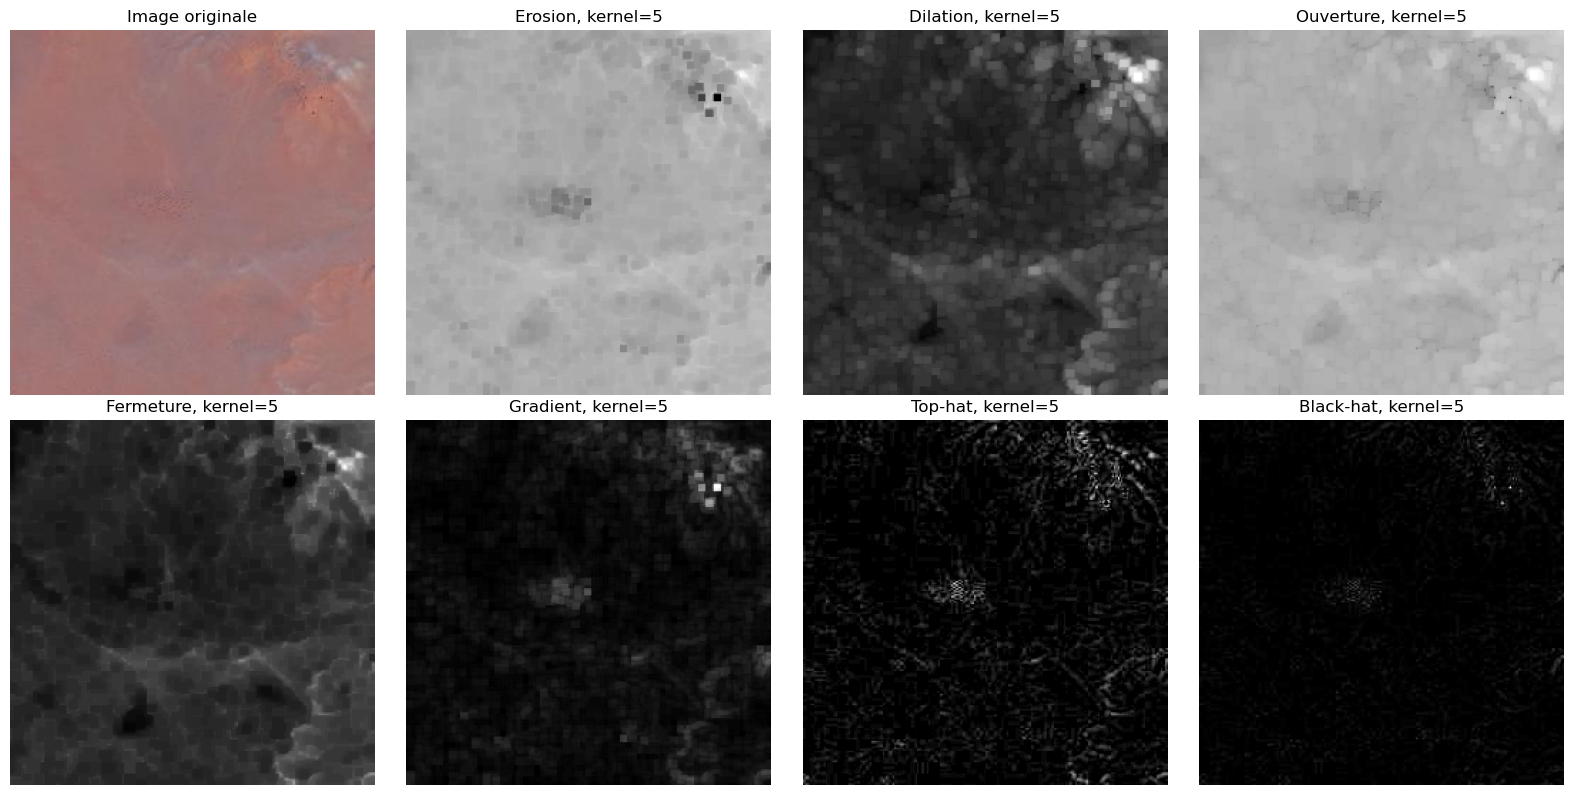


2. Gradients morphologiques


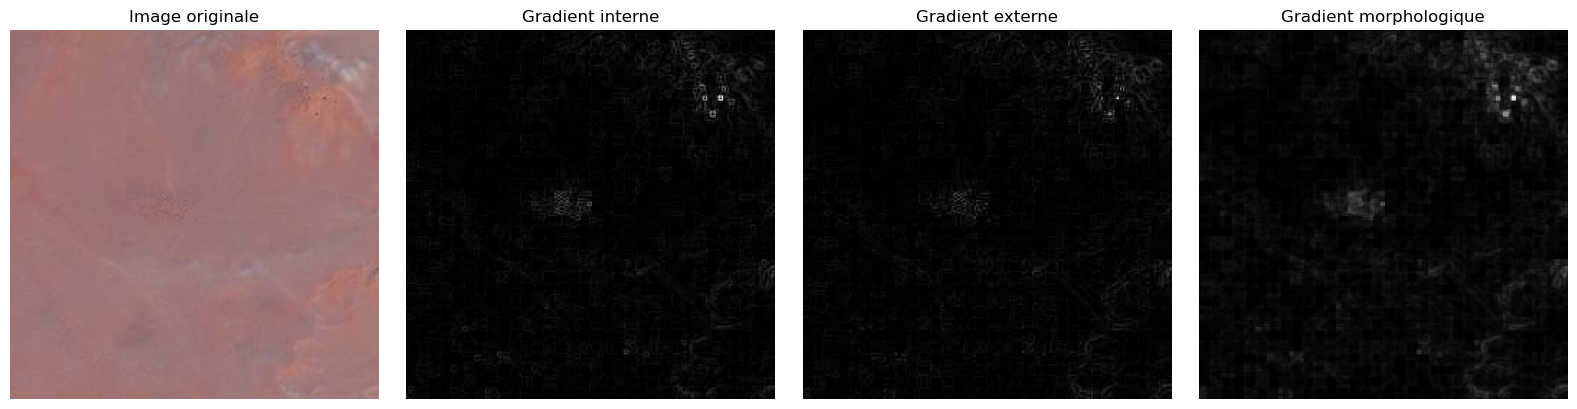


3. Comparaison des méthodes de segmentation


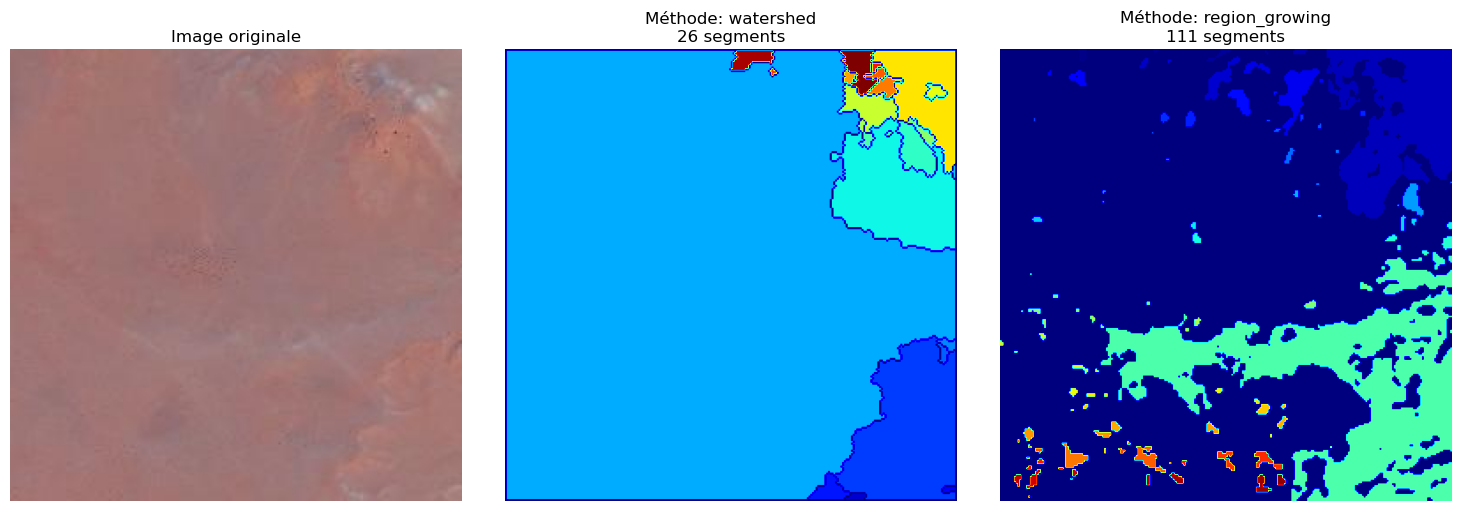


4. Analyse des textures


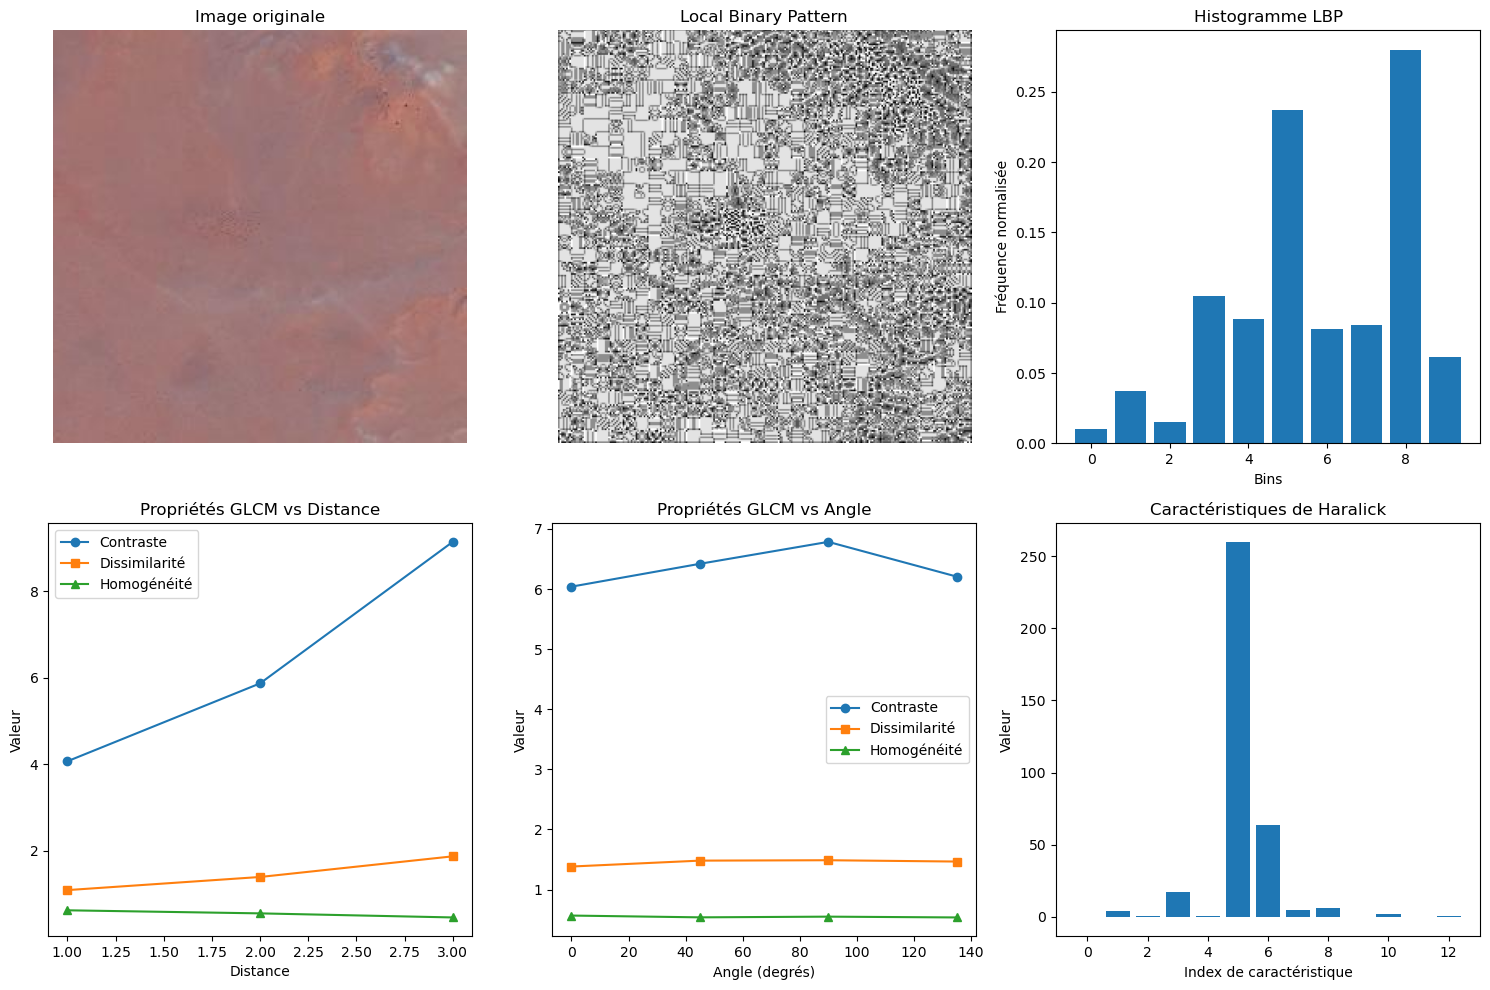


5. Segmentation et classification


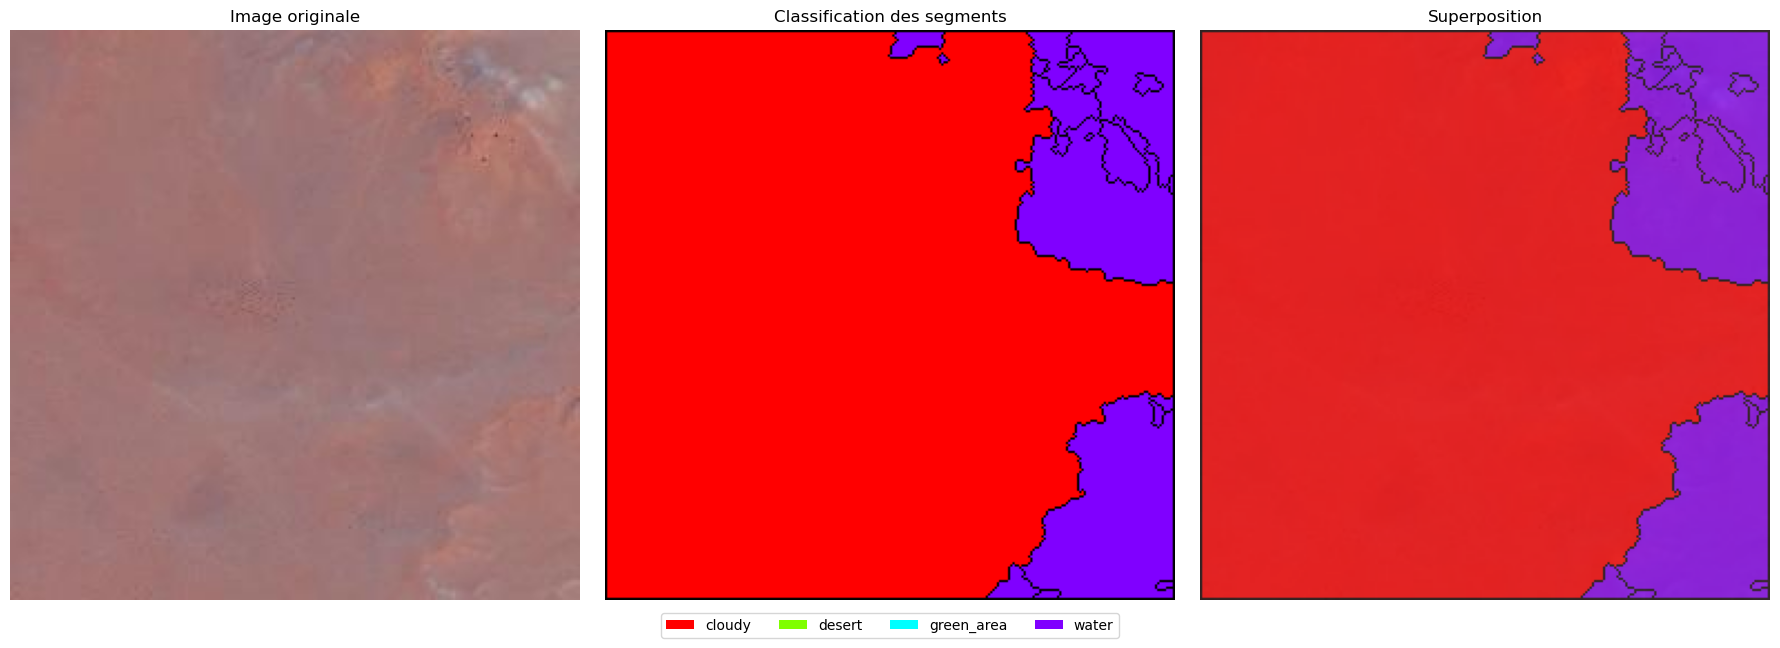

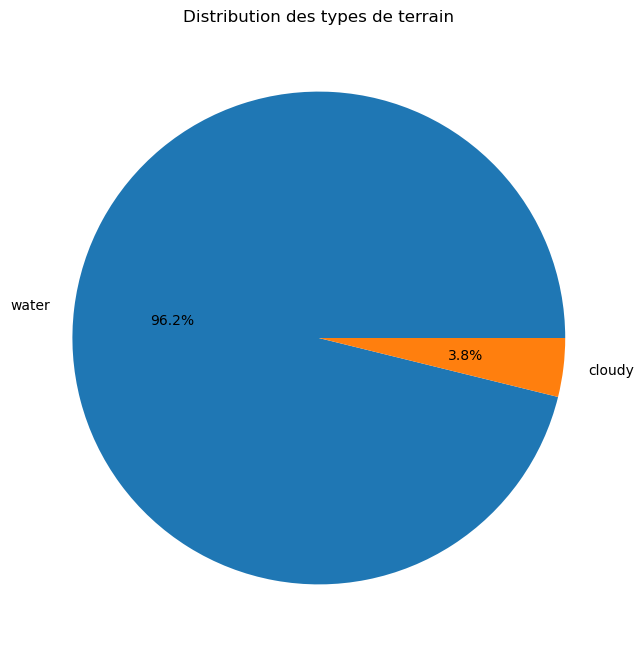


6. Résumé des résultats
Distribution des types de terrain:
  water: 25 segments (96.2%)
  cloudy: 1 segments (3.8%)

5. Comparaison des méthodes de segmentation
Évaluation de data\cloudy\train_10021.jpg
  Méthode watershed: 25 segments, taille médiane = 25.0 pixels
  Méthode region_growing: 3 segments, taille médiane = 99.0 pixels
Évaluation de data\desert\desert(1).jpg
  Méthode watershed: 26 segments, taille médiane = 36.5 pixels
  Méthode region_growing: 111 segments, taille médiane = 8.0 pixels

Statistiques pour watershed:
  Nombre moyen de segments: 25.5
  Taille médiane moyenne des segments: 30.8 pixels

Statistiques pour region_growing:
  Nombre moyen de segments: 57.0
  Taille médiane moyenne des segments: 53.5 pixels


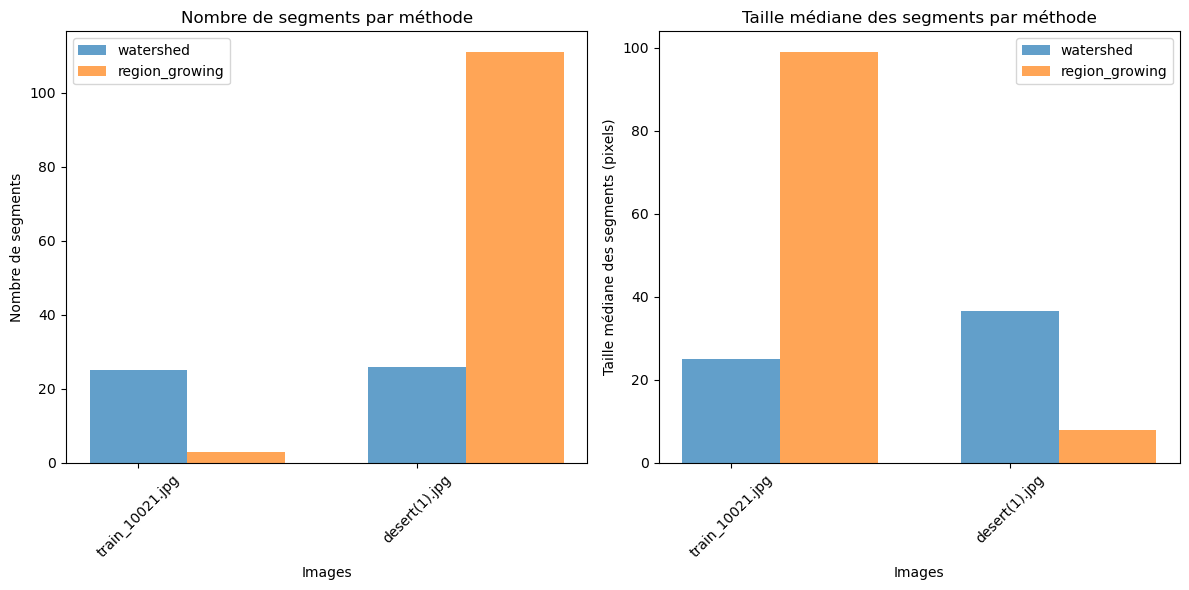


Analyse terminée en 14.7 secondes


In [145]:
def main():
    """
    Fonction principale pour exécuter l'analyse d'images satellitaires
    """
    import time
    start_time = time.time()
    
    # Définir le chemin vers les données
    data_path = "data"  # Ajustez selon votre configuration
    
    print("ANALYSE DE TEXTURES ET SEGMENTATION D'IMAGES SATELLITAIRES")
    print("="*70)
    
    # 1. Explorer le dataset
    print("\n1. Exploration du dataset")
    visualize_sample_images(data_path)
    
    # 2. Extraire les caractéristiques et entraîner le modèle
    print("\n2. Extraction des caractéristiques et entraînement du modèle")
    
    # Vérifier si un modèle préentraîné existe
    model_path = 'terrain_classifier_model.pkl'
    if os.path.exists(model_path):
        print("Chargement du modèle préentraîné...")
        model = joblib.load(model_path)
        
        # Récupérer les noms de classes depuis le dossier de données
        class_names = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
        print(f"Classes détectées: {class_names}")
    else:
        print("Entraînement d'un nouveau modèle...")
        # Limiter le nombre d'échantillons pour un entraînement plus rapide
        X, y, class_names = prepare_dataset(data_path, sample_limit=100)
        
        # Division en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        # Entraînement du modèle
        model = train_classifier(X_train, y_train)
        
        # Évaluation du modèle
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Précision sur l'ensemble de test: {accuracy:.4f}")
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        # Sauvegarder le modèle
        joblib.dump(model, model_path)
        print(f"Modèle sauvegardé dans {model_path}")
    
    # 3. Analyser l'importance des caractéristiques
    print("\n3. Analyse de l'importance des caractéristiques")
    top_features = analyze_feature_importance(model)
    
    # 4. Sélectionner des images de test et les analyser
    print("\n4. Analyse d'images de test")
    
    # Sélectionner une image par classe
    test_images = []
    for class_name in class_names:
        class_samples = glob.glob(os.path.join(data_path, class_name, '*.jpg'))
        if class_samples:
            test_images.append(class_samples[0])
    
    # Analyser chaque image de test
    for test_image in test_images[:2]:  # Limiter à 2 images pour la démo
        analyze_satellite_image(test_image, model, class_names)
    
    # 5. Comparer les méthodes de segmentation
    print("\n5. Comparaison des méthodes de segmentation")
    segmentation_results = evaluate_segmentation_methods(test_images[:2])
    
    execution_time = time.time() - start_time
    print(f"\nAnalyse terminée en {execution_time:.1f} secondes")

# Exécuter la fonction principale
if __name__ == "__main__":
    main()

In [147]:
import joblib

# Chemin où vous souhaitez sauvegarder le modèle
model_path = 'terrain_classifier_model.pkl'

# Sauvegarder le modèle
joblib.dump(model, model_path)

print(f"Modèle sauvegardé avec succès dans {model_path}")

Modèle sauvegardé avec succès dans terrain_classifier_model.pkl
